# Interrogating BERT (Seq2Seq)

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import copy
import tensorflow_hub as hub # pip install tensorflow-hub
from datetime import datetime

W0507 12:02:38.606049 140640207632256 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
!pip install bert-tensorflow
import bert # pip install bert-tensorflow
from bert import run_classifier
from bert import optimization
from bert import tokenization
from bert import modeling


     |████████████████████████████████| 71kB 18.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# 1.0 Data

First we get some data, nothing here is BERT specific, but as were training 

In [0]:
df_trn = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/squad_v2/train.csv")
df_tst = pd.read_csv("/content/gdrive/My Drive/Data Science/Low Shot NLP/datasets/squad_v2/test.csv")

Make sure we shuffle the data here or BERT fails

In [5]:
df_trn = df_trn.sample(frac=1)
df_tst = df_tst.sample(frac=1)

df_trn.sample(n=10)

,Title,Question,Context,Answer,Answer Start,Answer End,Is Impossible
45090,The_Sun_(United_Kingdom),How did the prospective publisher describe the...,Seizing the opportunity to increase his presen...,"a ""straightforward, honest newspaper""",206,243,False
16530,Westminster_Abbey,When was the organ first used?,The organ was built by Harrison & Harrison in ...,the coronation of King George VI,133,165,False
34680,Age_of_Enlightenment,Who created the argument for deep time?,Science came to play a leading role in Enlight...,geologist James Hutton,461,483,False
9401,United_Nations_Population_Fund,What does UNFPA not provide?,"The United Nations Population Fund (UNFPA), fo...",NaN,-1,-1,True
32739,Uranium,How many nuclei does uranium-235 usually divid...,Uranium-235 was the first isotope that was fou...,two,226,229,False
74483,Compact_disc,How were customers disadvantaged by the Philip...,The Compact Disc is an evolution of LaserDisc ...,NaN,-1,-1,True
48752,Switzerland,"What did Swiss voters agree to join on June 5,...",In 2002 Switzerland became a full member of th...,Schengen treaty,954,969,False
35545,Memory,What type of memory is secondarily employed in...,"In contrast, procedural memory (or implicit me...",NaN,-1,-1,True
47437,Alloy,Why was tin was rarely used for everyday use?,The term pewter covers a variety of alloys con...,too soft,102,110,False
73984,Quran,How many suras are in the Quran?,The Quran consists of 114 chapters of varying ...,114,22,25,False


Now, here we're training data based on the SQuAD dataset https://rajpurkar.github.io/SQuAD-explorer/. Now normally in question answering (we'll as far as I've seen so far in my studies which is probably not very) we need 3 pieces of data: Question, Answer, and Context. However the way Google trained on the SQuAD data in the BERT paper used more features than just the text, specifically they also use the start and end positions of the answer within the context. Ideally i'd like to keep the example as simple as possible so that we can concentrate on BERT, but I will follow with this necessity for now as I dont know how to easily factor it out.

In [0]:
DATA_A_COLUMN = 'Context'
DATA_B_COLUMN = 'Question'
LABEL_COLUMN = 'Answer'
START_COLUMN = 'Answer Start'
END_COLUMN = 'Answer End'
IMPOSSIBLE_COLUMN = 'Is Impossible'

# 2.0 Data Preprocessing
We'll need to transform our data into a format BERT understands. This involves three steps:
- First, we create  `InputExample`'s using the constructor provided in the BERT library.
- Second, we load the model specific tokenizer
- Third, we convert examples to features using parts 1 and 2

# 2.1 Input Features

So... in the classifications notebook (part 1) we saw how first we made every example in the train and test sets into instances of the InputExample class, in this class there was room for text_a and text_b which you would think naturally would be the class we'd use to do question answering... nope! Well maybe its hard to tell as I can't find any explicit tutorials on using BERT in any sequence to sequence tasks let alone question answering. In the official repo they demo question answering with SQUAD, but everything is so specific to the SQUAD data its not very usable. To give an example of how specific it is instead of importing bert.run_classifier we dont import bert.run_question_answering we import bert.run_squad.....

So why is it so specific, well two main reasons:
- They have a lot of preprocessing specifically for the SQUAD dataset

They have to call specific tokenization and parsing routines to get the data in the form they like, I don't like this being included as part of the high level apis like this as in our pipeline we dont use tokenization until further down, I would rather have a seperate package dedicated to cleaning an arbitrary dataset to the agnostic form that we can use.

- They have a very contrived loss function that needs more information that 'InputExample' holds 

This is understandable, we are using BERT as part of a wider net so we may need extra info to train or run our model, however again I think this could have been handled better. InputExample is inside of run_classifier even though we dont want to do classification here, and the equivalent for question answering doesnt exist. Instead we have SquadExample which looks similar but doesnt even inherit from the base class. Ideally in my mind there should be either a hierarchy of classes from the base version through to task specific through to dataset specific, or they should be super clear where they are making things dataset specific.

For these reasons im going to factor out any of the run_squad functions and code and define more question answering agnostic ones where possible and **always** highlight where im putting in SQUAD specific code (that is used in the wider net) so it is very clear what and how to factor it out. The hopefully this can be easily adapted for other sequence to sequence tasks.

In [0]:
class QAExample(bert.run_classifier.InputExample):
    
  def __init__(self, 
               guid, 
               text_a, 
               text_b=None, 
               label=0, 
               start_position=None,
               end_position=None,
               is_impossible=False):

      bert.run_classifier.InputExample.__init__(self, 
                                                guid, 
                                                text_a, 
                                                text_b,
                                                label)
      self.start_position = start_position
      self.end_position = end_position
      self.is_impossible = is_impossible

In [0]:
train_InputExamples = df_trn.apply(lambda x: QAExample(guid=100,
                                                       text_b=x[DATA_B_COLUMN],
                                                       text_a=x[DATA_A_COLUMN],
                                                       label=x[LABEL_COLUMN],
                                                       start_position=x[START_COLUMN],
                                                       end_position=x[END_COLUMN],
                                                       is_impossible=x[IMPOSSIBLE_COLUMN]), axis=1)

test_InputExamples = df_tst.apply(lambda x: QAExample(guid=100,
                                                      text_b=x[DATA_B_COLUMN],
                                                      text_a=x[DATA_A_COLUMN],
                                                      label=x[LABEL_COLUMN],
                                                      start_position=x[START_COLUMN],
                                                      end_position=x[END_COLUMN],
                                                      is_impossible=x[IMPOSSIBLE_COLUMN]), axis=1)

We still need the tokenizer from TF Hub, so this is the same as in notebook 1.

In [9]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"


"""Get the vocab file and casing info from the Hub module."""
with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
        vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                              tokenization_info["do_lower_case"]])
        
tokenizer = bert.tokenization.FullTokenizer(vocab_file=vocab_file, 
                                            do_lower_case=do_lower_case)

Instructions for updating:
Colocations handled automatically by placer.


W0507 12:04:06.685367 140640207632256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 12:04:08.727300 140640207632256 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [10]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

# 2.3 Examples to Features

Next... for the classification tasks we ran `run_classifier.convert_examples_to_features` on our InputExamples to convert them into features BERT understands. For question answering (using SQUAD) BERT has a dedicated `run_squad.convert_examples_to_features`. However we want something that we can at least understand how to edit for a more general case, even if we're using SQUAD here.

Lets first have another look at the stages we went through in the run_classifier version:

1. It has some house keeping to check for fake examples (we'll ignore that for now)
2. It tokenizes text_a and if it exists text_b
3. Depending on if text_b exists it limits the combined 'sequence' to the max_sequence_length
4. Then it creates 2 lists
    - The list of tokens with special tokens [SEP] etc
    - The list of type ids which is 0 for text_a and 0 for text_b
5. Next it converts the tokenized text to ids (which the language model needs to run)
6. Then it creates a new list, and input mask so it knows which of the tokens out of max_sequence_length are actual data and not just fillers
7. It pads our 3 lists: word_ids, type_ids, and input_mask; out to max_sequence_length with 0s
8. Then it passes these 3 lists with the label_id (which it made a mapping of earlier) to a new constructor called InputFeatures
9. Then parse it to InputFeatures which was just a class with attributes to hold the inputs expected by BERT core, and the label, and if the example is real.

######################### SOURCE CODE ###############################
```
class InputFeatures(object):
  """Classification A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example
```
######################### SOURCE CODE ###############################

Looking at the `InputFeatures` class in run_squad it looks like an extension of this one (although again not inherited), but with a ton of extra stuff. We already see that we had to extend `InputExample` with 3 extra fields. Here if we see below they produce a `run_squad.InputFeatures`with 8 extra fields and they've lost the is_real_example (that we never really used anyway). 

######################### SOURCE CODE ###############################
```
class InputFeatures(object):
  """SQUAD A single set of features of data."""

  def __init__(self,
               unique_id,
               example_index,
               doc_span_index,
               tokens,
               token_to_orig_map,
               token_is_max_context,
               input_ids,
               input_mask,
               segment_ids,
               start_position=None,
               end_position=None,
               is_impossible=None):
    self.unique_id = unique_id
    self.example_index = example_index
    self.doc_span_index = doc_span_index
    self.tokens = tokens
    self.token_to_orig_map = token_to_orig_map
    self.token_is_max_context = token_is_max_context
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.start_position = start_position
    self.end_position = end_position
    self.is_impossible = is_impossible
```
######################### SOURCE CODE ###############################

Now im not even going to try and break down the `run_squad.convert_examples_to_features` instead im going to create a new version of convert_examples_to_features based on `run_classifier.convert_examples_to_features`, what we shall try and do is:

- create a function that is similar to the run_classifier one we understood
- have it take an arbitrary InputFeatures class that can hold all of the input features we need
- have it pull these features from an arbitrary version of InputExample that is inherited from the base

For the InputFeatures class we shall inherit from the run_classifier.InputFeatures class and just hold the same extra 3 pieces of info we needed in InputExample.

Lets see how it will look...

In [0]:
class QAInputFeatures(bert.run_classifier.InputFeatures):
  """A single set of features of data specific for our SQUAD data, however we're inheriting from the base class"""
  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example,
               **kwargs):

    bert.run_classifier.InputFeatures.__init__(self,
                                               input_ids,
                                               input_mask,
                                               segment_ids,
                                               label_id,
                                               is_real_example)

    self.start_position = kwargs.get('start_position', -1)
    self.end_position = kwargs.get('end_position', -1)
    self.is_impossible = kwargs.get('is_impossible', False)
        

def convert_single_example(ex_index, 
                           example, 
                           label_list, 
                           max_seq_length,
                           tokenizer,
                           InputFeatures,
                           parse_extra_input_args=True):
  """Converts a single `InputExample` (arbitrary extension) into a single 
     `InputFeatures`.Almost all of this is straight from bert.run_classifier as 
     disected in notebook 1"""

  ### SAME AS CLASSIFICATION FUNCTION - START ###
  if isinstance(example, bert.run_classifier.PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)
  
  label_map = {}
  if label_list:
    for (i, label) in enumerate(label_list):
      label_map[label] = i
      label_id = label_map[example.label]
  else:
    label_map[None] = 0
    label_id = 0

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    bert.run_classifier._truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  if ex_index < 2:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %d)" % (example.label, label_id))
    
  ### SAME AS CLASSIFICATION FUNCTION - END ###
  
  # Gather the extra arguments that are in our `example` but not in the base 
  # `run_classifier.InputExample` and pass to our input features.
  
  standard_params = ['guid', 'text_a', 'text_b', 'label']
  extra_params = copy.deepcopy(vars(example))
  for param in standard_params:
    extra_params.pop(param)

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True,
      **extra_params)
  
  return feature


def convert_examples_to_features(examples, 
                                 label_list, 
                                 max_seq_length,
                                 tokenizer,
                                 InputFeatures,
                                 parse_extra_input_args=True):
  
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, 
                                     example, 
                                     label_list,
                                     max_seq_length, 
                                     tokenizer, 
                                     InputFeatures,
                                     parse_extra_input_args)

    features.append(feature)
  return features

In [12]:
MAX_SEQ_LENGTH = 256

# Convert our train and test features to InputFeatures that BERT understands.
train_features = convert_examples_to_features(examples=train_InputExamples,
                                              tokenizer=tokenizer,
                                              max_seq_length=MAX_SEQ_LENGTH,
                                              label_list=None,
                                              InputFeatures=QAInputFeatures,
                                              parse_extra_input_args=True)

test_features = convert_examples_to_features(examples=test_InputExamples,
                                             tokenizer=tokenizer,
                                             max_seq_length=MAX_SEQ_LENGTH,
                                             label_list=None,
                                             InputFeatures=QAInputFeatures,
                                             parse_extra_input_args=True)

INFO:tensorflow:Writing example 0 of 91160


I0507 12:04:10.887141 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 0 of 91160


INFO:tensorflow:*** Example ***


I0507 12:04:10.893824 140640207632256 <ipython-input-11-21899ed6642a>:101] *** Example ***


INFO:tensorflow:guid: 100


I0507 12:04:10.895920 140640207632256 <ipython-input-11-21899ed6642a>:102] guid: 100


INFO:tensorflow:tokens: [CLS] some poly ##cha ##ete ##s breed only once in their lives , while others breed almost continuously or through several breeding seasons . while most poly ##cha ##ete ##s remain of one sex all their lives , a significant percentage of species are full her ##ma ##ph ##rod ##ites or change sex during their lives . most poly ##cha ##ete ##s whose reproduction has been studied lack permanent go ##nad ##s , and it is uncertain how they produce o ##va and sperm . in a few species the rear of the body splits off and becomes a separate individual that lives just long enough to swim to a suitable environment , usually near the surface , and spawn . [SEP] what do some non - single - sex poly ##cha ##ete ##s do ? [SEP]


I0507 12:04:10.898063 140640207632256 <ipython-input-11-21899ed6642a>:104] tokens: [CLS] some poly ##cha ##ete ##s breed only once in their lives , while others breed almost continuously or through several breeding seasons . while most poly ##cha ##ete ##s remain of one sex all their lives , a significant percentage of species are full her ##ma ##ph ##rod ##ites or change sex during their lives . most poly ##cha ##ete ##s whose reproduction has been studied lack permanent go ##nad ##s , and it is uncertain how they produce o ##va and sperm . in a few species the rear of the body splits off and becomes a separate individual that lives just long enough to swim to a suitable environment , usually near the surface , and spawn . [SEP] what do some non - single - sex poly ##cha ##ete ##s do ? [SEP]


INFO:tensorflow:input_ids: 101 2070 26572 7507 12870 2015 8843 2069 2320 1999 2037 3268 1010 2096 2500 8843 2471 10843 2030 2083 2195 8119 3692 1012 2096 2087 26572 7507 12870 2015 3961 1997 2028 3348 2035 2037 3268 1010 1037 3278 7017 1997 2427 2024 2440 2014 2863 8458 14127 7616 2030 2689 3348 2076 2037 3268 1012 2087 26572 7507 12870 2015 3005 14627 2038 2042 3273 3768 4568 2175 25389 2015 1010 1998 2009 2003 9662 2129 2027 3965 1051 3567 1998 18047 1012 1999 1037 2261 2427 1996 4373 1997 1996 2303 19584 2125 1998 4150 1037 3584 3265 2008 3268 2074 2146 2438 2000 9880 2000 1037 7218 4044 1010 2788 2379 1996 3302 1010 1998 25645 1012 102 2054 2079 2070 2512 1011 2309 1011 3348 26572 7507 12870 2015 2079 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:04:10.900041 140640207632256 <ipython-input-11-21899ed6642a>:105] input_ids: 101 2070 26572 7507 12870 2015 8843 2069 2320 1999 2037 3268 1010 2096 2500 8843 2471 10843 2030 2083 2195 8119 3692 1012 2096 2087 26572 7507 12870 2015 3961 1997 2028 3348 2035 2037 3268 1010 1037 3278 7017 1997 2427 2024 2440 2014 2863 8458 14127 7616 2030 2689 3348 2076 2037 3268 1012 2087 26572 7507 12870 2015 3005 14627 2038 2042 3273 3768 4568 2175 25389 2015 1010 1998 2009 2003 9662 2129 2027 3965 1051 3567 1998 18047 1012 1999 1037 2261 2427 1996 4373 1997 1996 2303 19584 2125 1998 4150 1037 3584 3265 2008 3268 2074 2146 2438 2000 9880 2000 1037 7218 4044 1010 2788 2379 1996 3302 1010 1998 25645 1012 102 2054 2079 2070 2512 1011 2309 1011 3348 26572 7507 12870 2015 2079 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:04:10.902001 140640207632256 <ipython-input-11-21899ed6642a>:106] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:04:10.903816 140640207632256 <ipython-input-11-21899ed6642a>:107] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: change sex (id = 0)


I0507 12:04:10.905520 140640207632256 <ipython-input-11-21899ed6642a>:108] label: change sex (id = 0)


INFO:tensorflow:*** Example ***


I0507 12:04:10.911561 140640207632256 <ipython-input-11-21899ed6642a>:101] *** Example ***


INFO:tensorflow:guid: 100


I0507 12:04:10.913402 140640207632256 <ipython-input-11-21899ed6642a>:102] guid: 100


INFO:tensorflow:tokens: [CLS] according to the quran , god communicated with man and made his will known through signs and revelations . prophets , or ' messengers of god ' , received revelations and delivered them to humanity . the message has been identical and for all human ##kind . " nothing is said to you that was not said to the messengers before you , that your lord has at his command forgiveness as well as a most gr ##ie ##vo ##us penalty . " the revelation does not come directly from god to the prophets . angels acting as god ' s messengers deliver the divine revelation to them . this comes out in quran 42 : 51 , in which it is stated : " it is not for any mortal that god should speak to them , except by revelation , or from behind a veil , or by sending a messenger to reveal by his permission whatsoever he will . " [SEP] in what form does the quran say god sends his messages to people ? [SEP]


I0507 12:04:10.915282 140640207632256 <ipython-input-11-21899ed6642a>:104] tokens: [CLS] according to the quran , god communicated with man and made his will known through signs and revelations . prophets , or ' messengers of god ' , received revelations and delivered them to humanity . the message has been identical and for all human ##kind . " nothing is said to you that was not said to the messengers before you , that your lord has at his command forgiveness as well as a most gr ##ie ##vo ##us penalty . " the revelation does not come directly from god to the prophets . angels acting as god ' s messengers deliver the divine revelation to them . this comes out in quran 42 : 51 , in which it is stated : " it is not for any mortal that god should speak to them , except by revelation , or from behind a veil , or by sending a messenger to reveal by his permission whatsoever he will . " [SEP] in what form does the quran say god sends his messages to people ? [SEP]


INFO:tensorflow:input_ids: 101 2429 2000 1996 21288 1010 2643 24162 2007 2158 1998 2081 2010 2097 2124 2083 5751 1998 22191 1012 23172 1010 2030 1005 28938 1997 2643 1005 1010 2363 22191 1998 5359 2068 2000 8438 1012 1996 4471 2038 2042 7235 1998 2005 2035 2529 18824 1012 1000 2498 2003 2056 2000 2017 2008 2001 2025 2056 2000 1996 28938 2077 2017 1010 2008 2115 2935 2038 2012 2010 3094 17213 2004 2092 2004 1037 2087 24665 2666 6767 2271 6531 1012 1000 1996 11449 2515 2025 2272 3495 2013 2643 2000 1996 23172 1012 7048 3772 2004 2643 1005 1055 28938 8116 1996 7746 11449 2000 2068 1012 2023 3310 2041 1999 21288 4413 1024 4868 1010 1999 2029 2009 2003 3090 1024 1000 2009 2003 2025 2005 2151 9801 2008 2643 2323 3713 2000 2068 1010 3272 2011 11449 1010 2030 2013 2369 1037 15562 1010 2030 2011 6016 1037 11981 2000 7487 2011 2010 6656 18971 2002 2097 1012 1000 102 1999 2054 2433 2515 1996 21288 2360 2643 10255 2010 7696 2000 2111 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

I0507 12:04:10.917106 140640207632256 <ipython-input-11-21899ed6642a>:105] input_ids: 101 2429 2000 1996 21288 1010 2643 24162 2007 2158 1998 2081 2010 2097 2124 2083 5751 1998 22191 1012 23172 1010 2030 1005 28938 1997 2643 1005 1010 2363 22191 1998 5359 2068 2000 8438 1012 1996 4471 2038 2042 7235 1998 2005 2035 2529 18824 1012 1000 2498 2003 2056 2000 2017 2008 2001 2025 2056 2000 1996 28938 2077 2017 1010 2008 2115 2935 2038 2012 2010 3094 17213 2004 2092 2004 1037 2087 24665 2666 6767 2271 6531 1012 1000 1996 11449 2515 2025 2272 3495 2013 2643 2000 1996 23172 1012 7048 3772 2004 2643 1005 1055 28938 8116 1996 7746 11449 2000 2068 1012 2023 3310 2041 1999 21288 4413 1024 4868 1010 1999 2029 2009 2003 3090 1024 1000 2009 2003 2025 2005 2151 9801 2008 2643 2323 3713 2000 2068 1010 3272 2011 11449 1010 2030 2013 2369 1037 15562 1010 2030 2011 6016 1037 11981 2000 7487 2011 2010 6656 18971 2002 2097 1012 1000 102 1999 2054 2433 2515 1996 21288 2360 2643 10255 2010 7696 2000 2111 1029 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:04:10.919004 140640207632256 <ipython-input-11-21899ed6642a>:106] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:04:10.920846 140640207632256 <ipython-input-11-21899ed6642a>:107] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: signs and revelations (id = 0)


I0507 12:04:10.922544 140640207632256 <ipython-input-11-21899ed6642a>:108] label: signs and revelations (id = 0)


INFO:tensorflow:Writing example 10000 of 91160


I0507 12:04:42.324358 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 10000 of 91160


INFO:tensorflow:Writing example 20000 of 91160


I0507 12:05:14.126615 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 20000 of 91160


INFO:tensorflow:Writing example 30000 of 91160


I0507 12:05:44.987016 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 30000 of 91160


INFO:tensorflow:Writing example 40000 of 91160


I0507 12:06:16.740710 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 40000 of 91160


INFO:tensorflow:Writing example 50000 of 91160


I0507 12:06:47.452020 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 50000 of 91160


INFO:tensorflow:Writing example 60000 of 91160


I0507 12:07:18.641039 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 60000 of 91160


INFO:tensorflow:Writing example 70000 of 91160


I0507 12:07:50.635816 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 70000 of 91160


INFO:tensorflow:Writing example 80000 of 91160


I0507 12:08:21.453528 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 80000 of 91160


INFO:tensorflow:Writing example 90000 of 91160


I0507 12:08:53.362314 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 90000 of 91160


INFO:tensorflow:Writing example 0 of 25844


I0507 12:08:57.020177 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 0 of 25844


INFO:tensorflow:*** Example ***


I0507 12:08:57.025645 140640207632256 <ipython-input-11-21899ed6642a>:101] *** Example ***


INFO:tensorflow:guid: 100


I0507 12:08:57.028877 140640207632256 <ipython-input-11-21899ed6642a>:102] guid: 100


INFO:tensorflow:tokens: [CLS] in manufacturing the glass bulb , a type of " ribbon machine " is used . a continuous ribbon of glass is passed along a convey ##or belt , heated in a furnace , and then blown by precisely aligned air no ##zzle ##s through holes in the convey ##or belt into mold ##s . thus the glass bulbs are created . after the bulbs are blown , and cooled , they are cut off the ribbon machine ; a typical machine of this sort produces 50 , 000 bulbs per hour . the fi ##lam ##ent and its supports are assembled on a glass stem , which is fused to the bulb . the air is pumped out of the bulb , and the evacuation tube in the stem press is sealed by a flame . the bulb is then inserted into the lamp base , and the whole assembly tested . [SEP] what type of machine is not used in manufacturing light bulbs ? [SEP]


I0507 12:08:57.031911 140640207632256 <ipython-input-11-21899ed6642a>:104] tokens: [CLS] in manufacturing the glass bulb , a type of " ribbon machine " is used . a continuous ribbon of glass is passed along a convey ##or belt , heated in a furnace , and then blown by precisely aligned air no ##zzle ##s through holes in the convey ##or belt into mold ##s . thus the glass bulbs are created . after the bulbs are blown , and cooled , they are cut off the ribbon machine ; a typical machine of this sort produces 50 , 000 bulbs per hour . the fi ##lam ##ent and its supports are assembled on a glass stem , which is fused to the bulb . the air is pumped out of the bulb , and the evacuation tube in the stem press is sealed by a flame . the bulb is then inserted into the lamp base , and the whole assembly tested . [SEP] what type of machine is not used in manufacturing light bulbs ? [SEP]


INFO:tensorflow:input_ids: 101 1999 5814 1996 3221 20581 1010 1037 2828 1997 1000 10557 3698 1000 2003 2109 1012 1037 7142 10557 1997 3221 2003 2979 2247 1037 16636 2953 5583 1010 9685 1999 1037 17533 1010 1998 2059 10676 2011 10785 13115 2250 2053 17644 2015 2083 8198 1999 1996 16636 2953 5583 2046 18282 2015 1012 2947 1996 3221 25548 2024 2580 1012 2044 1996 25548 2024 10676 1010 1998 12981 1010 2027 2024 3013 2125 1996 10557 3698 1025 1037 5171 3698 1997 2023 4066 7137 2753 1010 2199 25548 2566 3178 1012 1996 10882 10278 4765 1998 2049 6753 2024 9240 2006 1037 3221 7872 1010 2029 2003 19660 2000 1996 20581 1012 1996 2250 2003 16486 2041 1997 1996 20581 1010 1998 1996 13982 7270 1999 1996 7872 2811 2003 10203 2011 1037 8457 1012 1996 20581 2003 2059 12889 2046 1996 10437 2918 1010 1998 1996 2878 3320 7718 1012 102 2054 2828 1997 3698 2003 2025 2109 1999 5814 2422 25548 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

I0507 12:08:57.035673 140640207632256 <ipython-input-11-21899ed6642a>:105] input_ids: 101 1999 5814 1996 3221 20581 1010 1037 2828 1997 1000 10557 3698 1000 2003 2109 1012 1037 7142 10557 1997 3221 2003 2979 2247 1037 16636 2953 5583 1010 9685 1999 1037 17533 1010 1998 2059 10676 2011 10785 13115 2250 2053 17644 2015 2083 8198 1999 1996 16636 2953 5583 2046 18282 2015 1012 2947 1996 3221 25548 2024 2580 1012 2044 1996 25548 2024 10676 1010 1998 12981 1010 2027 2024 3013 2125 1996 10557 3698 1025 1037 5171 3698 1997 2023 4066 7137 2753 1010 2199 25548 2566 3178 1012 1996 10882 10278 4765 1998 2049 6753 2024 9240 2006 1037 3221 7872 1010 2029 2003 19660 2000 1996 20581 1012 1996 2250 2003 16486 2041 1997 1996 20581 1010 1998 1996 13982 7270 1999 1996 7872 2811 2003 10203 2011 1037 8457 1012 1996 20581 2003 2059 12889 2046 1996 10437 2918 1010 1998 1996 2878 3320 7718 1012 102 2054 2828 1997 3698 2003 2025 2109 1999 5814 2422 25548 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:08:57.039179 140640207632256 <ipython-input-11-21899ed6642a>:106] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:08:57.041550 140640207632256 <ipython-input-11-21899ed6642a>:107] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: nan (id = 0)


I0507 12:08:57.044843 140640207632256 <ipython-input-11-21899ed6642a>:108] label: nan (id = 0)


INFO:tensorflow:*** Example ***


I0507 12:08:57.054788 140640207632256 <ipython-input-11-21899ed6642a>:101] *** Example ***


INFO:tensorflow:guid: 100


I0507 12:08:57.056518 140640207632256 <ipython-input-11-21899ed6642a>:102] guid: 100


INFO:tensorflow:tokens: [CLS] go ##rba ##chev also radically expanded the scope of g ##las ##nos ##t , stating that no subject was off - limits for open discussion in the media . even so , the cautious soviet intelligent ##sia took almost a year to begin pushing the boundaries to see if he meant what he said . for the first time , the communist party leader had appealed over the heads of central committee members for the people ' s support in exchange for expansion of liberties . the tactic proved successful : within two years political reform could no longer be side ##tra ##cked by party " conservatives . " an un ##int ##ended consequence was that having saved reform , go ##rba ##chev ' s move ultimately killed the very system it was designed to save . [SEP] what party was go ##rba ##chev in charge of ? [SEP]


I0507 12:08:57.058369 140640207632256 <ipython-input-11-21899ed6642a>:104] tokens: [CLS] go ##rba ##chev also radically expanded the scope of g ##las ##nos ##t , stating that no subject was off - limits for open discussion in the media . even so , the cautious soviet intelligent ##sia took almost a year to begin pushing the boundaries to see if he meant what he said . for the first time , the communist party leader had appealed over the heads of central committee members for the people ' s support in exchange for expansion of liberties . the tactic proved successful : within two years political reform could no longer be side ##tra ##cked by party " conservatives . " an un ##int ##ended consequence was that having saved reform , go ##rba ##chev ' s move ultimately killed the very system it was designed to save . [SEP] what party was go ##rba ##chev in charge of ? [SEP]


INFO:tensorflow:input_ids: 101 2175 28483 16179 2036 25796 4423 1996 9531 1997 1043 8523 15460 2102 1010 5517 2008 2053 3395 2001 2125 1011 6537 2005 2330 6594 1999 1996 2865 1012 2130 2061 1010 1996 17145 3354 9414 8464 2165 2471 1037 2095 2000 4088 6183 1996 7372 2000 2156 2065 2002 3214 2054 2002 2056 1012 2005 1996 2034 2051 1010 1996 4750 2283 3003 2018 12068 2058 1996 4641 1997 2430 2837 2372 2005 1996 2111 1005 1055 2490 1999 3863 2005 4935 1997 18271 1012 1996 19717 4928 3144 1024 2306 2048 2086 2576 5290 2071 2053 2936 2022 2217 6494 18141 2011 2283 1000 11992 1012 1000 2019 4895 18447 21945 9509 2001 2008 2383 5552 5290 1010 2175 28483 16179 1005 1055 2693 4821 2730 1996 2200 2291 2009 2001 2881 2000 3828 1012 102 2054 2283 2001 2175 28483 16179 1999 3715 1997 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

I0507 12:08:57.060544 140640207632256 <ipython-input-11-21899ed6642a>:105] input_ids: 101 2175 28483 16179 2036 25796 4423 1996 9531 1997 1043 8523 15460 2102 1010 5517 2008 2053 3395 2001 2125 1011 6537 2005 2330 6594 1999 1996 2865 1012 2130 2061 1010 1996 17145 3354 9414 8464 2165 2471 1037 2095 2000 4088 6183 1996 7372 2000 2156 2065 2002 3214 2054 2002 2056 1012 2005 1996 2034 2051 1010 1996 4750 2283 3003 2018 12068 2058 1996 4641 1997 2430 2837 2372 2005 1996 2111 1005 1055 2490 1999 3863 2005 4935 1997 18271 1012 1996 19717 4928 3144 1024 2306 2048 2086 2576 5290 2071 2053 2936 2022 2217 6494 18141 2011 2283 1000 11992 1012 1000 2019 4895 18447 21945 9509 2001 2008 2383 5552 5290 1010 2175 28483 16179 1005 1055 2693 4821 2730 1996 2200 2291 2009 2001 2881 2000 3828 1012 102 2054 2283 2001 2175 28483 16179 1999 3715 1997 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:08:57.063282 140640207632256 <ipython-input-11-21899ed6642a>:106] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 12:08:57.067166 140640207632256 <ipython-input-11-21899ed6642a>:107] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: Communist (id = 0)


I0507 12:08:57.071143 140640207632256 <ipython-input-11-21899ed6642a>:108] label: Communist (id = 0)


INFO:tensorflow:Writing example 10000 of 25844


I0507 12:09:27.608838 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 10000 of 25844


INFO:tensorflow:Writing example 20000 of 25844


I0507 12:09:58.270177 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 20000 of 25844


In [13]:
print("Length of training inputs matches with the original size of our dataset nicely", len(train_features))
print("And we can see the components that make up each training example, for example the vocab_ids of example 1:\n", train_features[0].input_ids)

Length of training inputs matches with the original size of our dataset nicely 91160
And we can see the components that make up each training example, for example the vocab_ids of example 1:
 [101, 2070, 26572, 7507, 12870, 2015, 8843, 2069, 2320, 1999, 2037, 3268, 1010, 2096, 2500, 8843, 2471, 10843, 2030, 2083, 2195, 8119, 3692, 1012, 2096, 2087, 26572, 7507, 12870, 2015, 3961, 1997, 2028, 3348, 2035, 2037, 3268, 1010, 1037, 3278, 7017, 1997, 2427, 2024, 2440, 2014, 2863, 8458, 14127, 7616, 2030, 2689, 3348, 2076, 2037, 3268, 1012, 2087, 26572, 7507, 12870, 2015, 3005, 14627, 2038, 2042, 3273, 3768, 4568, 2175, 25389, 2015, 1010, 1998, 2009, 2003, 9662, 2129, 2027, 3965, 1051, 3567, 1998, 18047, 1012, 1999, 1037, 2261, 2427, 1996, 4373, 1997, 1996, 2303, 19584, 2125, 1998, 4150, 1037, 3584, 3265, 2008, 3268, 2074, 2146, 2438, 2000, 9880, 2000, 1037, 7218, 4044, 1010, 2788, 2379, 1996, 3302, 1010, 1998, 25645, 1012, 102, 2054, 2079, 2070, 2512, 1011, 2309, 1011, 3348, 26572, 7507, 128

Note the 'train_features' are still python objects (lists etc) and BERT wants tensors, however how we parse in tensors is actually dealt with as part of the model in the next section.

# 3.0 Creating a model

Remembering from notebook 1 the general work flow is shown in this chart.

![image.png](attachment:image.png)

To run through quickly we want to call the train method (actually there are other methods like predict etc we will want to call later, but they all work in the same way so for here ill stick with training) on an estimator. This needs a train_input_fn which deals with data loading. We also have to initilise the estimator object which involves creating a config instace, and a model_fn, the model_fn is made by a model_fn creator which calls a create_model function...

So to simplify this down and understand this we really need to build 3 things:
- An instance of tf.estimator.RunConfig
- A train_input_fn which is a specific kind of function needed to run the estimator to train the data
- A model_fn which the estimator wraps around and "talks to" the train_input_function

There are couple of "function builders" but they are just wrappers that we dont absolutely need... 

Again lets focus on whats different between sequence to sequence (specifically SQuAD) and the classification example.

# 3.1 tf.estimator.RunConfig

Lets go with the same as notebook 1 as it worked!

In [0]:
# Model configs
SAVE_CHECKPOINTS_STEPS = 5000
SAVE_SUMMARY_STEPS = 500

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir="model",
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

Unfortunately we are not so lucky with the input_fn. However we can do something similar to what we did above for InputFeatures. Build something based on the `bert.run_classifier.input_fn_builder` but that takes in any of the extended variables. Lets look at the original  `bert.run_classifier.input_fn_builder`....

######################### SOURCE CODE ###############################
```
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn
```
######################### SOURCE CODE ###############################

We can see that it should be fairly easy to extend this for our arbitrary attributes. Lets try...




In [0]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []
  all_other_variables = {}
  
  # get non-standard vars from features
  standard_params = ['input_ids', 'input_mask', 'segment_ids', 'label_id',
                     'is_real_example']
  extra_params = copy.deepcopy(vars(features[0]))
  for param in standard_params:
    extra_params.pop(param)
  extra_param_keys = extra_params.keys()
  for ke in extra_param_keys:
    all_other_variables[ke] = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)
    for ke in extra_param_keys:
      all_other_variables[ke].append(getattr(feature, ke))

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]
    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    
    slices_dict = {
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32)
    }
    
    for ke in extra_param_keys:
      slices_dict[ke] = tf.constant(all_other_variables[ke], 
                                    shape=[num_examples], # TODO dynamically check variable size
                                    dtype=tf.int32)
    
    d = tf.data.Dataset.from_tensor_slices(slices_dict)

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(features=train_features,
                                  seq_length=MAX_SEQ_LENGTH,
                                  is_training=True,
                                  drop_remainder=False)

In [17]:
vars(train_features[1])['end_position']

103

We can see how the train_input_fn works if we pass some dummy params

In [18]:
train_input_fn({'batch_size': 32})

<DatasetV1Adapter shapes: {input_ids: (?, 256), input_mask: (?, 256), segment_ids: (?, 256), label_ids: (?,), start_position: (?,), end_position: (?,), is_impossible: (?,)}, types: {input_ids: tf.int32, input_mask: tf.int32, segment_ids: tf.int32, label_ids: tf.int32, start_position: tf.int32, end_position: tf.int32, is_impossible: tf.int32}>

In [19]:
bert_module.get_input_info_dict(signature='tokens')

{'input_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'input_mask': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>,
 'segment_ids': <hub.ParsedTensorInfo shape=(?, ?) dtype=int32 is_sparse=False>}

# 3.3 model_fn

Finally we arrive at the juciy bit, the model! this is the bit where we really have to disect the BERT black box code to understand fully whats going on and use this in the most agnostic manner. Now we already know we need to use TF Hub to get the model and weights, we also know we need it to take in at least 3 inputs to satisfy the model (we are actually passing more for our final layers/loss function to use). 

Below is from the official repo around squad but I have added some comments

In [0]:
def create_model(is_predicting, 
                 input_ids, 
                 input_mask, 
                 segment_ids):
  """Creates a classification model."""
  # Get the BERT model again from tf hub, this time setting trainable as true as we will fine tune it
  bert_module = hub.Module(
    BERT_MODEL_HUB,
    trainable=True)

  # We have our input tensors, the ones for the pre-trained bert are just being grouped here for convinience
  bert_inputs = dict(
    input_ids=input_ids,
    input_mask=input_mask,
    segment_ids=segment_ids)

  # We already saw earlier in the notebook, 'tokens' is the standard endpoint that gives the reference tensors coming out of BERT
  # Unlike 'tokenization_info' here we need to pass the inputs to get the outputs.
  bert_outputs = bert_module(
    inputs=bert_inputs,
    signature="tokens",
    as_dict=True)

  # From the tf hub docs for BERT we know we can use "pooled_output" for classification tasks on an entire sentence.
  # Or use "sequence_outputs" for token-level output. We want sequences here
  output_layer = bert_outputs["sequence_output"]
  
  # We have to get the shape in this way as its dynamic and .shape doesnt work with reshape
  final_hidden_shape = bert.modeling.get_shape_list(output_layer, expected_rank=3)
  batch_size = final_hidden_shape[0]
  seq_length = final_hidden_shape[1]
  hidden_size = final_hidden_shape[2]

  # Create final layer
  output_weights = tf.get_variable(
      "cls/squad/output_weights", [2, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "cls/squad/output_bias", [2], initializer=tf.zeros_initializer())
  
  reshape = [batch_size * seq_length, hidden_size]
  final_hidden_matrix = tf.reshape(output_layer,
                                   reshape)
  logits = tf.matmul(final_hidden_matrix, output_weights, transpose_b=True)
  logits = tf.nn.bias_add(logits, output_bias)

  logits = tf.reshape(logits, [batch_size, seq_length, 2])
  print("LOGITS SHAPE 1:", logits.shape)
  logits = tf.transpose(logits, [2, 0, 1])
  print("LOGITS SHAPE 2:", logits.shape)
  unstacked_logits = tf.unstack(logits, axis=0)
  print("LOGITS SHAPE 3:", len(unstacked_logits))
  (start_logits, end_logits) = (unstacked_logits[0], unstacked_logits[1])

  return (start_logits, end_logits)


def model_fn_builder(learning_rate,
                     num_train_steps, 
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, 
               labels, 
               mode, 
               params):
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)

    (start_logits, end_logits) = create_model(
        is_predicting=is_predicting,
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)

    tvars = tf.trainable_variables()

    initialized_variable_names = {}
    scaffold_fn = None

    tf.logging.info("**** Trainable Variables ****")
    for var in tvars:
      init_string = ""
      if var.name in initialized_variable_names:
        init_string = ", *INIT_FROM_CKPT*"
      tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
                      init_string)

    if mode != tf.estimator.ModeKeys.PREDICT:
      seq_length = modeling.get_shape_list(input_ids)[1]

      def compute_loss(logits, positions):
        one_hot_positions = tf.one_hot(
            positions, depth=seq_length, dtype=tf.float32)
        log_probs = tf.nn.log_softmax(logits, axis=-1)
        loss = -tf.reduce_mean(
            tf.reduce_sum(one_hot_positions * log_probs, axis=-1))
        return loss

      start_positions = features["start_position"]
      end_positions = features["end_position"]

      start_loss = compute_loss(start_logits, start_positions)
      end_loss = compute_loss(end_logits, end_positions)

      total_loss = (start_loss + end_loss) / 2.0

      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, False)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=total_loss,
          train_op=train_op)
      else:
        predictions = {
          "start_logits": start_logits,
          "end_logits": end_logits,
        }
        return tf.estimator.EstimatorSpec(mode=mode,
            predictions=predictions,
            loss=total_loss)
    else:
      (start_logits, end_logits) = create_model(
        is_predicting=is_predicting,
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids)

      predictions = {
        "start_logits": start_logits,
        "end_logits": end_logits,
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  return model_fn

## bert.optimization.create_optimizer

######################### SOURCE CODE ###############################
```
def create_optimizer(loss, init_lr, num_train_steps, num_warmup_steps, use_tpu):
  """Creates an optimizer training op."""
  global_step = tf.train.get_or_create_global_step()

  learning_rate = tf.constant(value=init_lr, shape=[], dtype=tf.float32)

  # Implements linear decay of the learning rate.
  learning_rate = tf.train.polynomial_decay(
      learning_rate,
      global_step,
      num_train_steps,
      end_learning_rate=0.0,
      power=1.0,
      cycle=False)

  # Implements linear warmup. I.e., if global_step < num_warmup_steps, the
  # learning rate will be `global_step/num_warmup_steps * init_lr`.
  if num_warmup_steps:
    global_steps_int = tf.cast(global_step, tf.int32)
    warmup_steps_int = tf.constant(num_warmup_steps, dtype=tf.int32)

    global_steps_float = tf.cast(global_steps_int, tf.float32)
    warmup_steps_float = tf.cast(warmup_steps_int, tf.float32)

    warmup_percent_done = global_steps_float / warmup_steps_float
    warmup_learning_rate = init_lr * warmup_percent_done

    is_warmup = tf.cast(global_steps_int < warmup_steps_int, tf.float32)
    learning_rate = (
        (1.0 - is_warmup) * learning_rate + is_warmup * warmup_learning_rate)

  # It is recommended that you use this optimizer for fine tuning, since this
  # is how the model was trained (note that the Adam m/v variables are NOT
  # loaded from init_checkpoint.)
  optimizer = AdamWeightDecayOptimizer(
      learning_rate=learning_rate,
      weight_decay_rate=0.01,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-6,
      exclude_from_weight_decay=["LayerNorm", "layer_norm", "bias"])
```
######################### SOURCE CODE ###############################

This is all quite straightforward, they are just defining an Adam optimizer with a linear learning rate decay. In addition they have the option of "warmup" which is the same logic FastAI used with ULMFiT in have slantend triangular learning rates, the idea is that you start low, build up to your max learning rate, and then linearly decrease.

## tf.estimator.EstimatorSpec

This is a standard class and is quite straightforward. As per the docs https://www.tensorflow.org/api_docs/python/tf/estimator/EstimatorSpec the EstimatorSpec is what is to be returned from any model  function and has various attributes around the mode, loss, train_op, etc and these must "fully define" the model to be run by the estimator. So the model function is just defineing the model and filling in this class object with the relevant tf.variables to be ran.

Now we have all of the (confusing) constituent pieces, we can put them together

In [50]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1

# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)
print(num_train_steps)
print(num_warmup_steps)

8546
854


In [51]:
model_fn = model_fn_builder(
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
    model_fn=model_fn,
    config=run_config,
    params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe8b7ff99b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0507 17:19:39.691406 140640207632256 estimator.py:201] Using config: {'_model_dir': 'model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe8b7ff99b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


# 4.0 Training

Now we train our model! We can use a Colab notebook running on Google's GPUs, or just do it locally.

Remember we built the estimator around the model_fn, now to call it we use the train_input_fn, we can also create other input functions and use them with the same estimator, depending on what data we want to pass (is it trian, test, val, adhoc predictions). All input functions look rather the same, as the diferentiation between training, evaluating, and predicting is determined by what method of the estimator we call, this sets a key (e.g. tf.estimator.ModeKeys.PREDICT) that our model_fn can deal with.

WARNING: BERTs pretty fat (as previously discussed) if you get a OOM error, or Dst tensor is not initialized, or something weird it could well be your out of memory (VRAM), I tried running this on my work and home laptop (home laptop having 4GB VRAM) and still got OOM, if thats the case I reccomend running it in colab, im not sure how much you are alloted, I feel it varies depending on demand... but every time I have tried I was able to run this.

In [40]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


I0507 12:44:00.094624 140640207632256 estimator.py:1111] Calling model_fn.


INFO:tensorflow:*** Features ***


I0507 12:44:00.097543 140640207632256 <ipython-input-37-859abd91b261>:70] *** Features ***


INFO:tensorflow:  name = end_position, shape = (?,)


I0507 12:44:00.099220 140640207632256 <ipython-input-37-859abd91b261>:72]   name = end_position, shape = (?,)


INFO:tensorflow:  name = input_ids, shape = (?, 256)


I0507 12:44:00.101015 140640207632256 <ipython-input-37-859abd91b261>:72]   name = input_ids, shape = (?, 256)


INFO:tensorflow:  name = input_mask, shape = (?, 256)


I0507 12:44:00.102779 140640207632256 <ipython-input-37-859abd91b261>:72]   name = input_mask, shape = (?, 256)


INFO:tensorflow:  name = is_impossible, shape = (?,)


I0507 12:44:00.104368 140640207632256 <ipython-input-37-859abd91b261>:72]   name = is_impossible, shape = (?,)


INFO:tensorflow:  name = label_ids, shape = (?,)


I0507 12:44:00.105871 140640207632256 <ipython-input-37-859abd91b261>:72]   name = label_ids, shape = (?,)


INFO:tensorflow:  name = segment_ids, shape = (?, 256)


I0507 12:44:00.107447 140640207632256 <ipython-input-37-859abd91b261>:72]   name = segment_ids, shape = (?, 256)


INFO:tensorflow:  name = start_position, shape = (?,)


I0507 12:44:00.109006 140640207632256 <ipython-input-37-859abd91b261>:72]   name = start_position, shape = (?,)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 12:44:04.251870 140640207632256 saver.py:1483] Saver not created because there are no variables in the graph to restore


LOGITS SHAPE 1: (?, ?, 2)
LOGITS SHAPE 2: (2, ?, ?)
LOGITS SHAPE 3: 2
INFO:tensorflow:**** Trainable Variables ****


I0507 12:44:04.405142 140640207632256 <ipython-input-37-859abd91b261>:91] **** Trainable Variables ****


INFO:tensorflow:  name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


I0507 12:44:04.406749 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


INFO:tensorflow:  name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


I0507 12:44:04.410979 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


INFO:tensorflow:  name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


I0507 12:44:04.413549 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.417185 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.420471 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.423514 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.427611 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.429415 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.432679 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.436141 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.438710 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.442115 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.445888 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.449239 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.452831 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.455067 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.457855 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.460661 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


I0507 12:44:04.462611 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.465020 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.467338 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.469759 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.471811 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.474150 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.476268 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.478792 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.481289 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.483788 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.486046 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.488561 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.490636 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.493172 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.495617 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.498093 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


I0507 12:44:04.500246 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.502639 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.504652 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.507093 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.509511 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.511932 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.514005 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.516427 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.518429 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.520773 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.523129 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.525139 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.527133 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.529533 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.532382 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.534747 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


I0507 12:44:04.536777 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.539128 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.541206 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.543712 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.546262 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.548686 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.550770 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.553219 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.555281 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.557692 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.560128 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.562274 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.564743 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.566794 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.569375 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.571934 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


I0507 12:44:04.574127 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.576550 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.578643 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.581055 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.583572 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.586074 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.588339 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.590821 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.592927 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.595502 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.598037 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.600127 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.602307 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.604909 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.607667 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.610170 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


I0507 12:44:04.612204 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.615095 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.618016 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.619873 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.622325 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.624706 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.627499 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.629486 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.631800 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.634533 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.636563 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.639318 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.642212 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.644571 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.647298 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.650117 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


I0507 12:44:04.651968 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.654345 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.656308 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.659693 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.661649 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.664320 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.666707 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.669056 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.672148 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.674896 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.677206 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.679594 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.682157 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.684859 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.687026 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.689274 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


I0507 12:44:04.692356 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.695116 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.697424 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.699341 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.702745 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.705470 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.707478 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.710613 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.713265 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.715532 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.718306 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.720118 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.722389 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.724354 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.727362 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.730164 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


I0507 12:44:04.734306 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.737048 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.740484 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.743808 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.747407 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.750617 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.755634 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.760150 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.763614 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.767022 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.771290 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.773974 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.777465 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.781888 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.785235 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.788081 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


I0507 12:44:04.792507 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.796123 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.799576 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.803867 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.806566 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.810047 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.813490 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.818044 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.822523 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.826062 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.829919 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.834342 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.837835 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.841293 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.844901 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.849976 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


I0507 12:44:04.853217 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.857411 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.860939 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.864189 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.867507 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.870966 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.874280 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.878103 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.882508 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.886199 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.890689 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.892514 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.893894 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.897211 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.900799 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.905156 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


I0507 12:44:04.908884 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.912343 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.916109 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


I0507 12:44:04.920071 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


I0507 12:44:04.924427 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


I0507 12:44:04.928200 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


I0507 12:44:04.931803 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


I0507 12:44:04.939783 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


I0507 12:44:04.941946 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.950580 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


I0507 12:44:04.952699 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.955369 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.958611 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 12:44:04.963424 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


I0507 12:44:04.967710 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


I0507 12:44:04.971033 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


I0507 12:44:04.973622 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.976165 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.979705 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.982280 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/pooler/dense/bias:0, shape = (768,)


I0507 12:44:04.984834 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/bert/pooler/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


I0507 12:44:04.988896 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


I0507 12:44:04.992165 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


I0507 12:44:04.994842 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


I0507 12:44:04.997468 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/output_bias:0, shape = (30522,)


I0507 12:44:05.000777 140640207632256 <ipython-input-37-859abd91b261>:97]   name = module/cls/predictions/output_bias:0, shape = (30522,)


INFO:tensorflow:  name = cls/squad/output_weights:0, shape = (2, 768)


I0507 12:44:05.003709 140640207632256 <ipython-input-37-859abd91b261>:97]   name = cls/squad/output_weights:0, shape = (2, 768)


INFO:tensorflow:  name = cls/squad/output_bias:0, shape = (2,)


I0507 12:44:05.006248 140640207632256 <ipython-input-37-859abd91b261>:97]   name = cls/squad/output_bias:0, shape = (2,)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


I0507 12:44:14.330563 140640207632256 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0507 12:44:14.334319 140640207632256 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0507 12:44:21.357977 140640207632256 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0507 12:44:26.155081 140640207632256 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0507 12:44:26.353627 140640207632256 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into model/model.ckpt.


I0507 12:45:44.365611 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 0 into model/model.ckpt.


INFO:tensorflow:loss = 1.5599132, step = 0


I0507 12:46:07.749310 140640207632256 basic_session_run_hooks.py:249] loss = 1.5599132, step = 0


INFO:tensorflow:global_step/sec: 0.559732


I0507 12:49:06.405774 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.559732


INFO:tensorflow:loss = 1.5527387, step = 100 (178.659 sec)


I0507 12:49:06.408507 140640207632256 basic_session_run_hooks.py:247] loss = 1.5527387, step = 100 (178.659 sec)


INFO:tensorflow:global_step/sec: 0.599282


I0507 12:51:53.272030 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599282


INFO:tensorflow:loss = 2.012983, step = 200 (166.866 sec)


I0507 12:51:53.274621 140640207632256 basic_session_run_hooks.py:247] loss = 2.012983, step = 200 (166.866 sec)


INFO:tensorflow:global_step/sec: 0.600942


I0507 12:54:39.677403 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600942


INFO:tensorflow:loss = 1.9766936, step = 300 (166.405 sec)


I0507 12:54:39.679849 140640207632256 basic_session_run_hooks.py:247] loss = 1.9766936, step = 300 (166.405 sec)


INFO:tensorflow:global_step/sec: 0.600163


I0507 12:57:26.298854 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600163


INFO:tensorflow:loss = 1.9131734, step = 400 (166.625 sec)


I0507 12:57:26.305248 140640207632256 basic_session_run_hooks.py:247] loss = 1.9131734, step = 400 (166.625 sec)


INFO:tensorflow:Saving checkpoints for 500 into model/model.ckpt.


I0507 13:00:11.373937 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.559955


I0507 13:00:24.884628 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.559955


INFO:tensorflow:loss = 1.573078, step = 500 (178.585 sec)


I0507 13:00:24.890154 140640207632256 basic_session_run_hooks.py:247] loss = 1.573078, step = 500 (178.585 sec)


INFO:tensorflow:global_step/sec: 0.599762


I0507 13:03:11.617691 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599762


INFO:tensorflow:loss = 1.402193, step = 600 (166.735 sec)


I0507 13:03:11.625249 140640207632256 basic_session_run_hooks.py:247] loss = 1.402193, step = 600 (166.735 sec)


INFO:tensorflow:global_step/sec: 0.600824


I0507 13:05:58.055654 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600824


INFO:tensorflow:loss = 2.0419009, step = 700 (166.433 sec)


I0507 13:05:58.057963 140640207632256 basic_session_run_hooks.py:247] loss = 2.0419009, step = 700 (166.433 sec)


INFO:tensorflow:global_step/sec: 0.599763


I0507 13:08:44.788085 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599763


INFO:tensorflow:loss = 2.147026, step = 800 (166.734 sec)


I0507 13:08:44.791883 140640207632256 basic_session_run_hooks.py:247] loss = 2.147026, step = 800 (166.734 sec)


INFO:tensorflow:global_step/sec: 0.60022


I0507 13:11:31.393542 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60022


INFO:tensorflow:loss = 2.1701999, step = 900 (166.604 sec)


I0507 13:11:31.395798 140640207632256 basic_session_run_hooks.py:247] loss = 2.1701999, step = 900 (166.604 sec)


INFO:tensorflow:Saving checkpoints for 1000 into model/model.ckpt.


I0507 13:14:16.272916 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 1000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.561458


I0507 13:14:29.501136 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.561458


INFO:tensorflow:loss = 0.901644, step = 1000 (178.108 sec)


I0507 13:14:29.503580 140640207632256 basic_session_run_hooks.py:247] loss = 0.901644, step = 1000 (178.108 sec)


INFO:tensorflow:global_step/sec: 0.599522


I0507 13:17:16.300652 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599522


INFO:tensorflow:loss = 2.0318, step = 1100 (166.805 sec)


I0507 13:17:16.308078 140640207632256 basic_session_run_hooks.py:247] loss = 2.0318, step = 1100 (166.805 sec)


INFO:tensorflow:global_step/sec: 0.601044


I0507 13:20:02.677896 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601044


INFO:tensorflow:loss = 2.3348212, step = 1200 (166.375 sec)


I0507 13:20:02.683266 140640207632256 basic_session_run_hooks.py:247] loss = 2.3348212, step = 1200 (166.375 sec)


INFO:tensorflow:global_step/sec: 0.601691


I0507 13:22:48.876068 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601691


INFO:tensorflow:loss = 0.95913416, step = 1300 (166.195 sec)


I0507 13:22:48.878216 140640207632256 basic_session_run_hooks.py:247] loss = 0.95913416, step = 1300 (166.195 sec)


INFO:tensorflow:global_step/sec: 0.60103


I0507 13:25:35.257194 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60103


INFO:tensorflow:loss = 1.7906194, step = 1400 (166.381 sec)


I0507 13:25:35.259353 140640207632256 basic_session_run_hooks.py:247] loss = 1.7906194, step = 1400 (166.381 sec)


INFO:tensorflow:Saving checkpoints for 1500 into model/model.ckpt.


I0507 13:28:19.969990 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 1500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.560953


I0507 13:28:33.525088 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.560953


INFO:tensorflow:loss = 1.9725144, step = 1500 (178.271 sec)


I0507 13:28:33.530656 140640207632256 basic_session_run_hooks.py:247] loss = 1.9725144, step = 1500 (178.271 sec)


INFO:tensorflow:global_step/sec: 0.59975


I0507 13:31:20.261260 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.59975


INFO:tensorflow:loss = 1.5217363, step = 1600 (166.736 sec)


I0507 13:31:20.266756 140640207632256 basic_session_run_hooks.py:247] loss = 1.5217363, step = 1600 (166.736 sec)


INFO:tensorflow:global_step/sec: 0.601062


I0507 13:34:06.633439 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601062


INFO:tensorflow:loss = 1.4885688, step = 1700 (166.369 sec)


I0507 13:34:06.635940 140640207632256 basic_session_run_hooks.py:247] loss = 1.4885688, step = 1700 (166.369 sec)


INFO:tensorflow:global_step/sec: 0.600935


I0507 13:36:53.040903 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600935


INFO:tensorflow:loss = 0.9786929, step = 1800 (166.409 sec)


I0507 13:36:53.045008 140640207632256 basic_session_run_hooks.py:247] loss = 0.9786929, step = 1800 (166.409 sec)


INFO:tensorflow:global_step/sec: 0.600475


I0507 13:39:39.575654 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600475


INFO:tensorflow:loss = 1.7670107, step = 1900 (166.536 sec)


I0507 13:39:39.581328 140640207632256 basic_session_run_hooks.py:247] loss = 1.7670107, step = 1900 (166.536 sec)


INFO:tensorflow:Saving checkpoints for 2000 into model/model.ckpt.


I0507 13:42:24.377407 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 2000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.56245


I0507 13:42:37.369304 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.56245


INFO:tensorflow:loss = 1.5578469, step = 2000 (177.791 sec)


I0507 13:42:37.371937 140640207632256 basic_session_run_hooks.py:247] loss = 1.5578469, step = 2000 (177.791 sec)


INFO:tensorflow:global_step/sec: 0.59918


I0507 13:45:24.264156 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.59918


INFO:tensorflow:loss = 1.8821659, step = 2100 (166.897 sec)


I0507 13:45:24.269230 140640207632256 basic_session_run_hooks.py:247] loss = 1.8821659, step = 2100 (166.897 sec)


INFO:tensorflow:global_step/sec: 0.600018


I0507 13:48:10.925862 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600018


INFO:tensorflow:loss = 2.0231237, step = 2200 (166.662 sec)


I0507 13:48:10.930992 140640207632256 basic_session_run_hooks.py:247] loss = 2.0231237, step = 2200 (166.662 sec)


INFO:tensorflow:global_step/sec: 0.601368


I0507 13:50:57.213422 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601368


INFO:tensorflow:loss = 1.4191628, step = 2300 (166.287 sec)


I0507 13:50:57.217757 140640207632256 basic_session_run_hooks.py:247] loss = 1.4191628, step = 2300 (166.287 sec)


INFO:tensorflow:global_step/sec: 0.601574


I0507 13:53:43.444076 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601574


INFO:tensorflow:loss = 0.5881211, step = 2400 (166.231 sec)


I0507 13:53:43.449141 140640207632256 basic_session_run_hooks.py:247] loss = 0.5881211, step = 2400 (166.231 sec)


INFO:tensorflow:Saving checkpoints for 2500 into model/model.ckpt.


I0507 13:56:28.262513 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 2500 into model/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0507 13:56:36.412072 140640207632256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 0.560989


I0507 13:56:41.700876 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.560989


INFO:tensorflow:loss = 1.3424475, step = 2500 (178.255 sec)


I0507 13:56:41.704281 140640207632256 basic_session_run_hooks.py:247] loss = 1.3424475, step = 2500 (178.255 sec)


INFO:tensorflow:global_step/sec: 0.599608


I0507 13:59:28.476398 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599608


INFO:tensorflow:loss = 1.2913258, step = 2600 (166.777 sec)


I0507 13:59:28.481530 140640207632256 basic_session_run_hooks.py:247] loss = 1.2913258, step = 2600 (166.777 sec)


INFO:tensorflow:global_step/sec: 0.601188


I0507 14:02:14.813931 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601188


INFO:tensorflow:loss = 1.9089462, step = 2700 (166.338 sec)


I0507 14:02:14.819287 140640207632256 basic_session_run_hooks.py:247] loss = 1.9089462, step = 2700 (166.338 sec)


INFO:tensorflow:global_step/sec: 0.601804


I0507 14:05:00.980875 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601804


INFO:tensorflow:loss = 2.0955954, step = 2800 (166.169 sec)


I0507 14:05:00.987849 140640207632256 basic_session_run_hooks.py:247] loss = 2.0955954, step = 2800 (166.169 sec)


INFO:tensorflow:global_step/sec: 0.601912


I0507 14:07:47.118137 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601912


INFO:tensorflow:loss = 2.2026765, step = 2900 (166.135 sec)


I0507 14:07:47.122457 140640207632256 basic_session_run_hooks.py:247] loss = 2.2026765, step = 2900 (166.135 sec)


INFO:tensorflow:Saving checkpoints for 3000 into model/model.ckpt.


I0507 14:10:31.804900 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 3000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.562427


I0507 14:10:44.918935 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.562427


INFO:tensorflow:loss = 1.4835355, step = 3000 (177.801 sec)


I0507 14:10:44.923233 140640207632256 basic_session_run_hooks.py:247] loss = 1.4835355, step = 3000 (177.801 sec)


INFO:tensorflow:global_step/sec: 0.599946


I0507 14:13:31.600713 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599946


INFO:tensorflow:loss = 2.1245182, step = 3100 (166.682 sec)


I0507 14:13:31.605213 140640207632256 basic_session_run_hooks.py:247] loss = 2.1245182, step = 3100 (166.682 sec)


INFO:tensorflow:global_step/sec: 0.600793


I0507 14:16:18.047391 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600793


INFO:tensorflow:loss = 1.3145002, step = 3200 (166.451 sec)


I0507 14:16:18.055767 140640207632256 basic_session_run_hooks.py:247] loss = 1.3145002, step = 3200 (166.451 sec)


INFO:tensorflow:global_step/sec: 0.600604


I0507 14:19:04.546412 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600604


INFO:tensorflow:loss = 1.3464427, step = 3300 (166.493 sec)


I0507 14:19:04.548825 140640207632256 basic_session_run_hooks.py:247] loss = 1.3464427, step = 3300 (166.493 sec)


INFO:tensorflow:global_step/sec: 0.601176


I0507 14:21:50.886967 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601176


INFO:tensorflow:loss = 1.3972924, step = 3400 (166.344 sec)


I0507 14:21:50.892783 140640207632256 basic_session_run_hooks.py:247] loss = 1.3972924, step = 3400 (166.344 sec)


INFO:tensorflow:Saving checkpoints for 3500 into model/model.ckpt.


I0507 14:24:35.619471 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 3500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.561844


I0507 14:24:48.872328 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.561844


INFO:tensorflow:loss = 1.5196521, step = 3500 (177.983 sec)


I0507 14:24:48.876006 140640207632256 basic_session_run_hooks.py:247] loss = 1.5196521, step = 3500 (177.983 sec)


INFO:tensorflow:global_step/sec: 0.599748


I0507 14:27:35.609091 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599748


INFO:tensorflow:loss = 1.6684488, step = 3600 (166.740 sec)


I0507 14:27:35.615879 140640207632256 basic_session_run_hooks.py:247] loss = 1.6684488, step = 3600 (166.740 sec)


INFO:tensorflow:global_step/sec: 0.600436


I0507 14:30:22.154588 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600436


INFO:tensorflow:loss = 0.9232773, step = 3700 (166.542 sec)


I0507 14:30:22.158176 140640207632256 basic_session_run_hooks.py:247] loss = 0.9232773, step = 3700 (166.542 sec)


INFO:tensorflow:global_step/sec: 0.601129


I0507 14:33:08.508234 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601129


INFO:tensorflow:loss = 1.3923943, step = 3800 (166.352 sec)


I0507 14:33:08.510628 140640207632256 basic_session_run_hooks.py:247] loss = 1.3923943, step = 3800 (166.352 sec)


INFO:tensorflow:global_step/sec: 0.601038


I0507 14:35:54.886926 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601038


INFO:tensorflow:loss = 2.2972171, step = 3900 (166.382 sec)


I0507 14:35:54.892437 140640207632256 basic_session_run_hooks.py:247] loss = 2.2972171, step = 3900 (166.382 sec)


INFO:tensorflow:Saving checkpoints for 4000 into model/model.ckpt.


I0507 14:38:39.470076 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 4000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.56176


I0507 14:38:52.898972 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.56176


INFO:tensorflow:loss = 1.2789211, step = 4000 (178.012 sec)


I0507 14:38:52.904655 140640207632256 basic_session_run_hooks.py:247] loss = 1.2789211, step = 4000 (178.012 sec)


INFO:tensorflow:global_step/sec: 0.600146


I0507 14:41:39.525047 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600146


INFO:tensorflow:loss = 1.0560484, step = 4100 (166.624 sec)


I0507 14:41:39.528743 140640207632256 basic_session_run_hooks.py:247] loss = 1.0560484, step = 4100 (166.624 sec)


INFO:tensorflow:global_step/sec: 0.600683


I0507 14:44:26.002070 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600683


INFO:tensorflow:loss = 1.179403, step = 4200 (166.477 sec)


I0507 14:44:26.006115 140640207632256 basic_session_run_hooks.py:247] loss = 1.179403, step = 4200 (166.477 sec)


INFO:tensorflow:global_step/sec: 0.600418


I0507 14:47:12.552875 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600418


INFO:tensorflow:loss = 2.5204296, step = 4300 (166.551 sec)


I0507 14:47:12.557242 140640207632256 basic_session_run_hooks.py:247] loss = 2.5204296, step = 4300 (166.551 sec)


INFO:tensorflow:global_step/sec: 0.601148


I0507 14:49:58.901284 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601148


INFO:tensorflow:loss = 1.6264389, step = 4400 (166.348 sec)


I0507 14:49:58.905151 140640207632256 basic_session_run_hooks.py:247] loss = 1.6264389, step = 4400 (166.348 sec)


INFO:tensorflow:Saving checkpoints for 4500 into model/model.ckpt.


I0507 14:52:43.722952 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 4500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.561074


I0507 14:52:57.130892 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.561074


INFO:tensorflow:loss = 1.3940417, step = 4500 (178.228 sec)


I0507 14:52:57.133016 140640207632256 basic_session_run_hooks.py:247] loss = 1.3940417, step = 4500 (178.228 sec)


INFO:tensorflow:global_step/sec: 0.59989


I0507 14:55:43.828206 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.59989


INFO:tensorflow:loss = 1.2308716, step = 4600 (166.701 sec)


I0507 14:55:43.833577 140640207632256 basic_session_run_hooks.py:247] loss = 1.2308716, step = 4600 (166.701 sec)


INFO:tensorflow:global_step/sec: 0.600156


I0507 14:58:30.451646 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600156


INFO:tensorflow:loss = 1.1991537, step = 4700 (166.620 sec)


I0507 14:58:30.453841 140640207632256 basic_session_run_hooks.py:247] loss = 1.1991537, step = 4700 (166.620 sec)


INFO:tensorflow:global_step/sec: 0.600321


I0507 15:01:17.029532 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600321


INFO:tensorflow:loss = 1.2021866, step = 4800 (166.580 sec)


I0507 15:01:17.033559 140640207632256 basic_session_run_hooks.py:247] loss = 1.2021866, step = 4800 (166.580 sec)


INFO:tensorflow:global_step/sec: 0.600304


I0507 15:04:03.611586 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600304


INFO:tensorflow:loss = 1.4835079, step = 4900 (166.586 sec)


I0507 15:04:03.619994 140640207632256 basic_session_run_hooks.py:247] loss = 1.4835079, step = 4900 (166.586 sec)


INFO:tensorflow:Saving checkpoints for 5000 into model/model.ckpt.


I0507 15:06:48.325355 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 5000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.558278


I0507 15:07:02.733905 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.558278


INFO:tensorflow:loss = 1.5684016, step = 5000 (179.119 sec)


I0507 15:07:02.738593 140640207632256 basic_session_run_hooks.py:247] loss = 1.5684016, step = 5000 (179.119 sec)


INFO:tensorflow:global_step/sec: 0.600091


I0507 15:09:49.375326 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600091


INFO:tensorflow:loss = 0.8617857, step = 5100 (166.640 sec)


I0507 15:09:49.378866 140640207632256 basic_session_run_hooks.py:247] loss = 0.8617857, step = 5100 (166.640 sec)


INFO:tensorflow:global_step/sec: 0.60082


I0507 15:12:35.814369 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60082


INFO:tensorflow:loss = 0.9552602, step = 5200 (166.440 sec)


I0507 15:12:35.818853 140640207632256 basic_session_run_hooks.py:247] loss = 0.9552602, step = 5200 (166.440 sec)


INFO:tensorflow:global_step/sec: 0.600611


I0507 15:15:22.311635 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600611


INFO:tensorflow:loss = 0.98362124, step = 5300 (166.498 sec)


I0507 15:15:22.316504 140640207632256 basic_session_run_hooks.py:247] loss = 0.98362124, step = 5300 (166.498 sec)


INFO:tensorflow:global_step/sec: 0.600676


I0507 15:18:08.790616 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600676


INFO:tensorflow:loss = 1.903906, step = 5400 (166.478 sec)


I0507 15:18:08.795000 140640207632256 basic_session_run_hooks.py:247] loss = 1.903906, step = 5400 (166.478 sec)


INFO:tensorflow:Saving checkpoints for 5500 into model/model.ckpt.


I0507 15:20:53.593148 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 5500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.560892


I0507 15:21:07.077898 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.560892


INFO:tensorflow:loss = 1.5976715, step = 5500 (178.288 sec)


I0507 15:21:07.083439 140640207632256 basic_session_run_hooks.py:247] loss = 1.5976715, step = 5500 (178.288 sec)


INFO:tensorflow:global_step/sec: 0.600619


I0507 15:23:53.572732 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600619


INFO:tensorflow:loss = 0.78732526, step = 5600 (166.495 sec)


I0507 15:23:53.578263 140640207632256 basic_session_run_hooks.py:247] loss = 0.78732526, step = 5600 (166.495 sec)


INFO:tensorflow:global_step/sec: 0.60163


I0507 15:26:39.787835 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60163


INFO:tensorflow:loss = 1.0423548, step = 5700 (166.212 sec)


I0507 15:26:39.789919 140640207632256 basic_session_run_hooks.py:247] loss = 1.0423548, step = 5700 (166.212 sec)


INFO:tensorflow:global_step/sec: 0.60115


I0507 15:29:26.135735 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60115


INFO:tensorflow:loss = 0.81681615, step = 5800 (166.350 sec)


I0507 15:29:26.139913 140640207632256 basic_session_run_hooks.py:247] loss = 0.81681615, step = 5800 (166.350 sec)


INFO:tensorflow:global_step/sec: 0.601339


I0507 15:32:12.431302 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601339


INFO:tensorflow:loss = 1.1943074, step = 5900 (166.298 sec)


I0507 15:32:12.437527 140640207632256 basic_session_run_hooks.py:247] loss = 1.1943074, step = 5900 (166.298 sec)


INFO:tensorflow:Saving checkpoints for 6000 into model/model.ckpt.


I0507 15:34:57.173078 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 6000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.562191


I0507 15:35:10.306853 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.562191


INFO:tensorflow:loss = 0.84201926, step = 6000 (177.871 sec)


I0507 15:35:10.308881 140640207632256 basic_session_run_hooks.py:247] loss = 0.84201926, step = 6000 (177.871 sec)


INFO:tensorflow:global_step/sec: 0.59966


I0507 15:37:57.068003 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.59966


INFO:tensorflow:loss = 1.3674338, step = 6100 (166.765 sec)


I0507 15:37:57.073603 140640207632256 basic_session_run_hooks.py:247] loss = 1.3674338, step = 6100 (166.765 sec)


INFO:tensorflow:global_step/sec: 0.60036


I0507 15:40:43.634601 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60036


INFO:tensorflow:loss = 1.4122756, step = 6200 (166.568 sec)


I0507 15:40:43.641584 140640207632256 basic_session_run_hooks.py:247] loss = 1.4122756, step = 6200 (166.568 sec)


INFO:tensorflow:global_step/sec: 0.600832


I0507 15:43:30.070473 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600832


INFO:tensorflow:loss = 1.0239348, step = 6300 (166.431 sec)


I0507 15:43:30.072503 140640207632256 basic_session_run_hooks.py:247] loss = 1.0239348, step = 6300 (166.431 sec)


INFO:tensorflow:global_step/sec: 0.601063


I0507 15:46:16.442384 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.601063


INFO:tensorflow:loss = 0.86485684, step = 6400 (166.374 sec)


I0507 15:46:16.446047 140640207632256 basic_session_run_hooks.py:247] loss = 0.86485684, step = 6400 (166.374 sec)


INFO:tensorflow:Saving checkpoints for 6500 into model/model.ckpt.


I0507 15:49:01.574477 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 6500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.55973


I0507 15:49:15.100058 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.55973


INFO:tensorflow:loss = 1.6884377, step = 6500 (178.657 sec)


I0507 15:49:15.102952 140640207632256 basic_session_run_hooks.py:247] loss = 1.6884377, step = 6500 (178.657 sec)


INFO:tensorflow:global_step/sec: 0.599665


I0507 15:52:01.859988 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599665


INFO:tensorflow:loss = 1.286237, step = 6600 (166.761 sec)


I0507 15:52:01.864372 140640207632256 basic_session_run_hooks.py:247] loss = 1.286237, step = 6600 (166.761 sec)


INFO:tensorflow:global_step/sec: 0.600632


I0507 15:54:48.351334 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600632


INFO:tensorflow:loss = 0.5088699, step = 6700 (166.489 sec)


I0507 15:54:48.353524 140640207632256 basic_session_run_hooks.py:247] loss = 0.5088699, step = 6700 (166.489 sec)


INFO:tensorflow:global_step/sec: 0.600283


I0507 15:57:34.939530 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600283


INFO:tensorflow:loss = 1.1310029, step = 6800 (166.588 sec)


I0507 15:57:34.942005 140640207632256 basic_session_run_hooks.py:247] loss = 1.1310029, step = 6800 (166.588 sec)


INFO:tensorflow:global_step/sec: 0.600577


I0507 16:00:21.446196 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600577


INFO:tensorflow:loss = 1.9938022, step = 6900 (166.507 sec)


I0507 16:00:21.448934 140640207632256 basic_session_run_hooks.py:247] loss = 1.9938022, step = 6900 (166.507 sec)


INFO:tensorflow:Saving checkpoints for 7000 into model/model.ckpt.


I0507 16:03:05.916857 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 7000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.560777


I0507 16:03:19.770117 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.560777


INFO:tensorflow:loss = 1.8498383, step = 7000 (178.327 sec)


I0507 16:03:19.775775 140640207632256 basic_session_run_hooks.py:247] loss = 1.8498383, step = 7000 (178.327 sec)


INFO:tensorflow:global_step/sec: 0.599423


I0507 16:06:06.597250 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599423


INFO:tensorflow:loss = 1.4092505, step = 7100 (166.824 sec)


I0507 16:06:06.599690 140640207632256 basic_session_run_hooks.py:247] loss = 1.4092505, step = 7100 (166.824 sec)


INFO:tensorflow:global_step/sec: 0.600888


I0507 16:08:53.017663 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600888


INFO:tensorflow:loss = 0.51143485, step = 7200 (166.421 sec)


I0507 16:08:53.020389 140640207632256 basic_session_run_hooks.py:247] loss = 0.51143485, step = 7200 (166.421 sec)


INFO:tensorflow:global_step/sec: 0.60081


I0507 16:11:39.459673 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60081


INFO:tensorflow:loss = 1.1322128, step = 7300 (166.445 sec)


I0507 16:11:39.464935 140640207632256 basic_session_run_hooks.py:247] loss = 1.1322128, step = 7300 (166.445 sec)


INFO:tensorflow:global_step/sec: 0.600222


I0507 16:14:26.064659 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600222


INFO:tensorflow:loss = 1.0128152, step = 7400 (166.606 sec)


I0507 16:14:26.071190 140640207632256 basic_session_run_hooks.py:247] loss = 1.0128152, step = 7400 (166.606 sec)


INFO:tensorflow:Saving checkpoints for 7500 into model/model.ckpt.


I0507 16:17:10.989163 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 7500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.560748


I0507 16:17:24.397865 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.560748


INFO:tensorflow:loss = 1.042392, step = 7500 (178.333 sec)


I0507 16:17:24.404494 140640207632256 basic_session_run_hooks.py:247] loss = 1.042392, step = 7500 (178.333 sec)


INFO:tensorflow:global_step/sec: 0.599389


I0507 16:20:11.234380 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599389


INFO:tensorflow:loss = 0.90936714, step = 7600 (166.832 sec)


I0507 16:20:11.236577 140640207632256 basic_session_run_hooks.py:247] loss = 0.90936714, step = 7600 (166.832 sec)


INFO:tensorflow:global_step/sec: 0.600293


I0507 16:22:57.819615 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600293


INFO:tensorflow:loss = 1.2439544, step = 7700 (166.587 sec)


I0507 16:22:57.823620 140640207632256 basic_session_run_hooks.py:247] loss = 1.2439544, step = 7700 (166.587 sec)


INFO:tensorflow:global_step/sec: 0.59995


I0507 16:25:44.500110 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.59995


INFO:tensorflow:loss = 1.4404504, step = 7800 (166.680 sec)


I0507 16:25:44.504062 140640207632256 basic_session_run_hooks.py:247] loss = 1.4404504, step = 7800 (166.680 sec)


INFO:tensorflow:global_step/sec: 0.600449


I0507 16:28:31.042127 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600449


INFO:tensorflow:loss = 0.9908432, step = 7900 (166.540 sec)


I0507 16:28:31.044417 140640207632256 basic_session_run_hooks.py:247] loss = 0.9908432, step = 7900 (166.540 sec)


INFO:tensorflow:Saving checkpoints for 8000 into model/model.ckpt.


I0507 16:31:15.671828 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 8000 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.562739


I0507 16:31:28.744311 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.562739


INFO:tensorflow:loss = 0.6246643, step = 8000 (177.704 sec)


I0507 16:31:28.748528 140640207632256 basic_session_run_hooks.py:247] loss = 0.6246643, step = 8000 (177.704 sec)


INFO:tensorflow:global_step/sec: 0.599778


I0507 16:34:15.472851 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.599778


INFO:tensorflow:loss = 1.0269452, step = 8100 (166.730 sec)


I0507 16:34:15.478465 140640207632256 basic_session_run_hooks.py:247] loss = 1.0269452, step = 8100 (166.730 sec)


INFO:tensorflow:global_step/sec: 0.600465


I0507 16:37:02.010397 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600465


INFO:tensorflow:loss = 1.163284, step = 8200 (166.540 sec)


I0507 16:37:02.018329 140640207632256 basic_session_run_hooks.py:247] loss = 1.163284, step = 8200 (166.540 sec)


INFO:tensorflow:global_step/sec: 0.600319


I0507 16:39:48.588518 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.600319


INFO:tensorflow:loss = 0.69579566, step = 8300 (166.572 sec)


I0507 16:39:48.590751 140640207632256 basic_session_run_hooks.py:247] loss = 0.69579566, step = 8300 (166.572 sec)


INFO:tensorflow:global_step/sec: 0.60111


I0507 16:42:34.947439 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.60111


INFO:tensorflow:loss = 1.1872427, step = 8400 (166.359 sec)


I0507 16:42:34.949713 140640207632256 basic_session_run_hooks.py:247] loss = 1.1872427, step = 8400 (166.359 sec)


INFO:tensorflow:Saving checkpoints for 8500 into model/model.ckpt.


I0507 16:45:19.734612 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 8500 into model/model.ckpt.


INFO:tensorflow:global_step/sec: 0.56139


I0507 16:45:33.076682 140640207632256 basic_session_run_hooks.py:680] global_step/sec: 0.56139


INFO:tensorflow:loss = 1.0768231, step = 8500 (178.131 sec)


I0507 16:45:33.081128 140640207632256 basic_session_run_hooks.py:247] loss = 1.0768231, step = 8500 (178.131 sec)


INFO:tensorflow:Saving checkpoints for 8546 into model/model.ckpt.


I0507 16:46:48.078591 140640207632256 basic_session_run_hooks.py:594] Saving checkpoints for 8546 into model/model.ckpt.


INFO:tensorflow:Loss for final step: 1.5159724.


I0507 16:47:00.203478 140640207632256 estimator.py:359] Loss for final step: 1.5159724.


Training took time  4:04:35.751680


Now let's use our test data to see how well our model did. Notice on the estimator call we call evaluate so our model function knows what to do (evaluate).

In [0]:
test_input_fn = input_fn_builder(features=test_features,
                                  seq_length=MAX_SEQ_LENGTH,
                                  is_training=False,
                                  drop_remainder=False)

In [53]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


I0507 17:20:13.509607 140640207632256 estimator.py:1111] Calling model_fn.


INFO:tensorflow:*** Features ***


I0507 17:20:13.511428 140640207632256 <ipython-input-49-9eaf96e91117>:70] *** Features ***


INFO:tensorflow:  name = end_position, shape = (?,)


I0507 17:20:13.513400 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = end_position, shape = (?,)


INFO:tensorflow:  name = input_ids, shape = (?, 256)


I0507 17:20:13.515190 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = input_ids, shape = (?, 256)


INFO:tensorflow:  name = input_mask, shape = (?, 256)


I0507 17:20:13.518401 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = input_mask, shape = (?, 256)


INFO:tensorflow:  name = is_impossible, shape = (?,)


I0507 17:20:13.521930 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = is_impossible, shape = (?,)


INFO:tensorflow:  name = label_ids, shape = (?,)


I0507 17:20:13.524377 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = label_ids, shape = (?,)


INFO:tensorflow:  name = segment_ids, shape = (?, 256)


I0507 17:20:13.529025 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = segment_ids, shape = (?, 256)


INFO:tensorflow:  name = start_position, shape = (?,)


I0507 17:20:13.531225 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = start_position, shape = (?,)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 17:20:15.875952 140640207632256 saver.py:1483] Saver not created because there are no variables in the graph to restore


LOGITS SHAPE 1: (?, ?, 2)
LOGITS SHAPE 2: (2, ?, ?)
LOGITS SHAPE 3: 2
INFO:tensorflow:**** Trainable Variables ****


I0507 17:20:16.034579 140640207632256 <ipython-input-49-9eaf96e91117>:91] **** Trainable Variables ****


INFO:tensorflow:  name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


I0507 17:20:16.036291 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


INFO:tensorflow:  name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


I0507 17:20:16.037953 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


INFO:tensorflow:  name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


I0507 17:20:16.042325 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.045136 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.048250 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.050807 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.053546 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.057000 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.060063 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.062190 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.065136 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.067234 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.070059 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.072786 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.074578 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.077486 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.079367 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.081505 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


I0507 17:20:16.083394 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.085223 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.087126 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.089068 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.091194 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.093055 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.094896 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.097005 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.098887 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.100663 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.102540 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.104373 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.106345 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.108572 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.110438 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.112276 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


I0507 17:20:16.114143 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.116282 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.118127 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.119969 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.121847 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.123655 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.125802 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.127629 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.129492 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.131356 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.133456 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.135313 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.137372 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.139576 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.141566 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.143779 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


I0507 17:20:16.145831 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.148048 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.150027 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.152236 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.154278 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.156282 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.158480 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.160699 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.162739 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.164705 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.166992 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.169005 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.171178 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.173159 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.175380 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.177580 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


I0507 17:20:16.179796 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.181779 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.183964 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.185951 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.188194 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.190160 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.192381 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.194378 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.196449 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.198626 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.200644 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.202869 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.204839 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.207098 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.209108 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.211311 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


I0507 17:20:16.213315 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.215501 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.217542 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.219943 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.221954 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.224159 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.226152 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.228475 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.230492 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.232711 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.234709 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.237056 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.239069 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.241271 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.243291 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.245285 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


I0507 17:20:16.247578 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.249886 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.252848 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.262700 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.276602 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.288887 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.292336 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.295859 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.299685 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.304542 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.308894 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.312623 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.315585 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.318365 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.322022 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.324535 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


I0507 17:20:16.327110 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.330279 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.332888 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.335181 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.338287 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.340661 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.343662 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.346201 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.348758 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.352100 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.354755 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.357544 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.359945 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.362491 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.365117 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.368545 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


I0507 17:20:16.370538 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.373139 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.376236 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.378928 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.381272 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.383882 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.386617 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.388985 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.392269 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.394676 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.397072 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.399808 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.402468 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.404893 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.407312 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.409783 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


I0507 17:20:16.411848 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.415057 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.417476 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.419608 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.422122 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.424602 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.427234 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.429754 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.432197 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.434648 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.437421 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.439995 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.442690 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.445173 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.447889 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.450339 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


I0507 17:20:16.453289 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.455796 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.458342 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.460794 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.463244 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.465701 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.468199 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.470660 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.473128 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.475244 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.477660 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.480228 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.482657 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.485364 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.487684 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.490269 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


I0507 17:20:16.492761 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.495469 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.497793 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


I0507 17:20:16.500231 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


I0507 17:20:16.502701 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


I0507 17:20:16.505705 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


I0507 17:20:16.509268 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


I0507 17:20:16.511142 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


I0507 17:20:16.514435 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.517317 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


I0507 17:20:16.520569 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.522666 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.525122 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 17:20:16.527617 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


I0507 17:20:16.530098 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


I0507 17:20:16.532805 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


I0507 17:20:16.534899 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.537357 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.540678 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.543998 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/pooler/dense/bias:0, shape = (768,)


I0507 17:20:16.546426 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/pooler/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


I0507 17:20:16.548491 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


I0507 17:20:16.551033 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


I0507 17:20:16.554290 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


I0507 17:20:16.556410 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/output_bias:0, shape = (30522,)


I0507 17:20:16.559878 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/output_bias:0, shape = (30522,)


INFO:tensorflow:  name = cls/squad/output_weights:0, shape = (2, 768)


I0507 17:20:16.562229 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = cls/squad/output_weights:0, shape = (2, 768)


INFO:tensorflow:  name = cls/squad/output_bias:0, shape = (2,)


I0507 17:20:16.564744 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = cls/squad/output_bias:0, shape = (2,)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


I0507 17:20:26.348538 140640207632256 estimator.py:1113] Done calling model_fn.


Instructions for updating:
Use tf.cast instead.


W0507 17:20:26.353353 140640207632256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/metrics_impl.py:363: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Starting evaluation at 2019-05-07T17:20:26Z


I0507 17:20:26.381050 140640207632256 evaluation.py:257] Starting evaluation at 2019-05-07T17:20:26Z


INFO:tensorflow:Graph was finalized.


I0507 17:20:27.787863 140640207632256 monitored_session.py:222] Graph was finalized.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


W0507 17:20:27.797494 140640207632256 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/model.ckpt-8546


I0507 17:20:27.801079 140640207632256 saver.py:1270] Restoring parameters from model/model.ckpt-8546


INFO:tensorflow:Running local_init_op.


I0507 17:20:29.952175 140640207632256 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0507 17:20:30.177752 140640207632256 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-05-07-17:28:26


I0507 17:28:26.446002 140640207632256 evaluation.py:277] Finished evaluation at 2019-05-07-17:28:26


INFO:tensorflow:Saving dict for global step 8546: global_step = 8546, loss = 1.3794538


I0507 17:28:26.448151 140640207632256 estimator.py:1979] Saving dict for global step 8546: global_step = 8546, loss = 1.3794538


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8546: model/model.ckpt-8546


I0507 17:28:30.800055 140640207632256 estimator.py:2039] Saving 'checkpoint_path' summary for global step 8546: model/model.ckpt-8546


{'global_step': 8546, 'loss': 1.3794538}

This called the evaluate method which can return a series of metrics automatically. However as mentioned there isnt the best choice of metrics available natively in Tensorflow so we will actually demo making predictions by making predictions on the whole test set and then evaluating our own metrics in Python.

Also note: BERTs pretty good :o

To make predictions we need a quick pipeline that does all of the data-prep stages we mentioned in this notebook, we can actually do that super cleanly when we dont spend ages pulling everything apart.

In [56]:
df_tst.iloc[1]

Title                              Dissolution_of_the_Soviet_Union
Question                    What party was Gorbachev in charge of?
Context          Gorbachev also radically expanded the scope of...
Answer                                                   Communist
Answer Start                                                   282
Answer End                                                     291
Is Impossible                                                False
Name: 13373, dtype: object

In [0]:
def get_prediction(question, context):
    """
    Helper function to run the pipeline for a list of examples answer
    """
    
    # As in 2.1. get input exaple object for the prediction example
    input_example = QAExample(guid=100,
                              text_b=question,
                              text_a=context,
                              label='UNKNOWN',
                              start_position=-1,
                              end_position=-1,
                              is_impossible=False)

    # As in 2.3 convert to the classes that BERT will ultimately understand (still in python format here)
    input_features = convert_examples_to_features(examples=[input_example],
                                                  tokenizer=tokenizer,
                                                  max_seq_length=MAX_SEQ_LENGTH,
                                                  label_list=None,
                                                  InputFeatures=QAInputFeatures,
                                                  parse_extra_input_args=True)
    
    # As in 3.2 we need an input function for the estimator, this just converts the data above to tensors to serve to the estimator
    predict_input_fn = input_fn_builder(features=test_features,
                                        seq_length=MAX_SEQ_LENGTH,
                                        is_training=False,
                                        drop_remainder=False)
    
    # Run the model this time on .predict which as defined by our model_fn will return probabilities and labels
    predictions = estimator.predict(predict_input_fn)
    
    # Returns a list of tuples (sentence, probs, label) for each example we passed
    return predictions

In [59]:
predictions = get_prediction(df_tst.iloc[1]["Question"], df_tst.iloc[1]["Context"])
predictions

INFO:tensorflow:Writing example 0 of 1


I0507 18:57:26.724272 140640207632256 <ipython-input-11-21899ed6642a>:143] Writing example 0 of 1


INFO:tensorflow:*** Example ***


I0507 18:57:26.730182 140640207632256 <ipython-input-11-21899ed6642a>:101] *** Example ***


INFO:tensorflow:guid: 100


I0507 18:57:26.732617 140640207632256 <ipython-input-11-21899ed6642a>:102] guid: 100


INFO:tensorflow:tokens: [CLS] go ##rba ##chev also radically expanded the scope of g ##las ##nos ##t , stating that no subject was off - limits for open discussion in the media . even so , the cautious soviet intelligent ##sia took almost a year to begin pushing the boundaries to see if he meant what he said . for the first time , the communist party leader had appealed over the heads of central committee members for the people ' s support in exchange for expansion of liberties . the tactic proved successful : within two years political reform could no longer be side ##tra ##cked by party " conservatives . " an un ##int ##ended consequence was that having saved reform , go ##rba ##chev ' s move ultimately killed the very system it was designed to save . [SEP] what party was go ##rba ##chev in charge of ? [SEP]


I0507 18:57:26.734794 140640207632256 <ipython-input-11-21899ed6642a>:104] tokens: [CLS] go ##rba ##chev also radically expanded the scope of g ##las ##nos ##t , stating that no subject was off - limits for open discussion in the media . even so , the cautious soviet intelligent ##sia took almost a year to begin pushing the boundaries to see if he meant what he said . for the first time , the communist party leader had appealed over the heads of central committee members for the people ' s support in exchange for expansion of liberties . the tactic proved successful : within two years political reform could no longer be side ##tra ##cked by party " conservatives . " an un ##int ##ended consequence was that having saved reform , go ##rba ##chev ' s move ultimately killed the very system it was designed to save . [SEP] what party was go ##rba ##chev in charge of ? [SEP]


INFO:tensorflow:input_ids: 101 2175 28483 16179 2036 25796 4423 1996 9531 1997 1043 8523 15460 2102 1010 5517 2008 2053 3395 2001 2125 1011 6537 2005 2330 6594 1999 1996 2865 1012 2130 2061 1010 1996 17145 3354 9414 8464 2165 2471 1037 2095 2000 4088 6183 1996 7372 2000 2156 2065 2002 3214 2054 2002 2056 1012 2005 1996 2034 2051 1010 1996 4750 2283 3003 2018 12068 2058 1996 4641 1997 2430 2837 2372 2005 1996 2111 1005 1055 2490 1999 3863 2005 4935 1997 18271 1012 1996 19717 4928 3144 1024 2306 2048 2086 2576 5290 2071 2053 2936 2022 2217 6494 18141 2011 2283 1000 11992 1012 1000 2019 4895 18447 21945 9509 2001 2008 2383 5552 5290 1010 2175 28483 16179 1005 1055 2693 4821 2730 1996 2200 2291 2009 2001 2881 2000 3828 1012 102 2054 2283 2001 2175 28483 16179 1999 3715 1997 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

I0507 18:57:26.736687 140640207632256 <ipython-input-11-21899ed6642a>:105] input_ids: 101 2175 28483 16179 2036 25796 4423 1996 9531 1997 1043 8523 15460 2102 1010 5517 2008 2053 3395 2001 2125 1011 6537 2005 2330 6594 1999 1996 2865 1012 2130 2061 1010 1996 17145 3354 9414 8464 2165 2471 1037 2095 2000 4088 6183 1996 7372 2000 2156 2065 2002 3214 2054 2002 2056 1012 2005 1996 2034 2051 1010 1996 4750 2283 3003 2018 12068 2058 1996 4641 1997 2430 2837 2372 2005 1996 2111 1005 1055 2490 1999 3863 2005 4935 1997 18271 1012 1996 19717 4928 3144 1024 2306 2048 2086 2576 5290 2071 2053 2936 2022 2217 6494 18141 2011 2283 1000 11992 1012 1000 2019 4895 18447 21945 9509 2001 2008 2383 5552 5290 1010 2175 28483 16179 1005 1055 2693 4821 2730 1996 2200 2291 2009 2001 2881 2000 3828 1012 102 2054 2283 2001 2175 28483 16179 1999 3715 1997 1029 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 18:57:26.739644 140640207632256 <ipython-input-11-21899ed6642a>:106] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0507 18:57:26.740976 140640207632256 <ipython-input-11-21899ed6642a>:107] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: UNKNOWN (id = 0)


I0507 18:57:26.742491 140640207632256 <ipython-input-11-21899ed6642a>:108] label: UNKNOWN (id = 0)


<generator object EstimatorV2.predict at 0x7fe8b22918e0>

In [64]:
[i for i in predictions]

INFO:tensorflow:Calling model_fn.


I0507 18:58:39.651034 140640207632256 estimator.py:1111] Calling model_fn.


INFO:tensorflow:*** Features ***


I0507 18:58:39.653340 140640207632256 <ipython-input-49-9eaf96e91117>:70] *** Features ***


INFO:tensorflow:  name = end_position, shape = (?,)


I0507 18:58:39.655284 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = end_position, shape = (?,)


INFO:tensorflow:  name = input_ids, shape = (?, 256)


I0507 18:58:39.657561 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = input_ids, shape = (?, 256)


INFO:tensorflow:  name = input_mask, shape = (?, 256)


I0507 18:58:39.660014 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = input_mask, shape = (?, 256)


INFO:tensorflow:  name = is_impossible, shape = (?,)


I0507 18:58:39.661990 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = is_impossible, shape = (?,)


INFO:tensorflow:  name = label_ids, shape = (?,)


I0507 18:58:39.663765 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = label_ids, shape = (?,)


INFO:tensorflow:  name = segment_ids, shape = (?, 256)


I0507 18:58:39.665680 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = segment_ids, shape = (?, 256)


INFO:tensorflow:  name = start_position, shape = (?,)


I0507 18:58:39.667610 140640207632256 <ipython-input-49-9eaf96e91117>:72]   name = start_position, shape = (?,)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 18:58:42.226395 140640207632256 saver.py:1483] Saver not created because there are no variables in the graph to restore


LOGITS SHAPE 1: (?, ?, 2)
LOGITS SHAPE 2: (2, ?, ?)
LOGITS SHAPE 3: 2
INFO:tensorflow:**** Trainable Variables ****


I0507 18:58:42.402205 140640207632256 <ipython-input-49-9eaf96e91117>:91] **** Trainable Variables ****


INFO:tensorflow:  name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


I0507 18:58:42.404072 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/word_embeddings:0, shape = (30522, 768)


INFO:tensorflow:  name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


I0507 18:58:42.407850 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/token_type_embeddings:0, shape = (2, 768)


INFO:tensorflow:  name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


I0507 18:58:42.411397 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/position_embeddings:0, shape = (512, 768)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.414968 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.418567 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/embeddings/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.421991 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.426468 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.429743 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.432683 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.434710 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.436903 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.439102 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.441034 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.443045 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.444985 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.446998 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.448939 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.450746 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


I0507 18:58:42.452745 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.454653 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.456540 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_0/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.458610 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.460695 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.462636 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.464607 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.466461 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.468270 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.470175 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.472074 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.474022 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.476181 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.478172 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.480242 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.482163 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


I0507 18:58:42.484158 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.486213 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.488118 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_1/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.490019 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.491963 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.493995 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.495937 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.497700 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.499621 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.501489 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.503357 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.505456 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.507388 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.509616 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.511389 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.513455 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


I0507 18:58:42.515417 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.517335 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.519123 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_2/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.521102 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.523025 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.524984 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.526950 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.528963 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.531208 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.533273 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.535861 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.537899 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.540030 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.542013 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.544008 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.546075 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


I0507 18:58:42.548045 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.549992 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.551911 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_3/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.553776 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.555828 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.557789 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.559783 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.561715 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.563896 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.565808 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.567832 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.569858 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.571794 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.573710 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.575666 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.577972 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


I0507 18:58:42.580083 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.581969 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.583918 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_4/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.585858 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.588147 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.590125 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.592112 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.594188 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.596184 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.598382 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.600269 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.602126 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.604015 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.605918 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.608018 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.610250 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


I0507 18:58:42.612276 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.614606 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.616650 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_5/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.618933 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.620919 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.622877 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.625195 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.627452 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.629913 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.631693 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.633705 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.636096 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.638163 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.640209 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.642161 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.644158 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


I0507 18:58:42.646236 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.648297 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.650523 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_6/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.652461 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.654531 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.656833 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.659182 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.661251 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.663404 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.665546 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.668062 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.670011 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.672045 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.674455 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.676201 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.678614 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


I0507 18:58:42.680752 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.682794 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.684912 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_7/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.687546 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.689482 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.691489 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.693577 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.695612 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.697664 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.699995 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.702008 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.704033 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.706571 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.708400 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.710759 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.712747 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


I0507 18:58:42.714705 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.716635 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.718578 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_8/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.720913 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.722952 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.724932 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.727139 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.729809 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.731786 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.733849 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.736284 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.738085 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.740598 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.742552 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.745413 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.747060 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


I0507 18:58:42.748751 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.750670 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.752633 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_9/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.755175 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.758574 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.760631 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.763750 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.765285 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.766793 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.768470 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.769942 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.773980 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.776621 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.779639 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.782323 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.785501 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


I0507 18:58:42.789005 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.792291 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.796040 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_10/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


I0507 18:58:42.799569 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/query/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


I0507 18:58:42.802748 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/query/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


I0507 18:58:42.806694 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/key/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


I0507 18:58:42.810936 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/key/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


I0507 18:58:42.814880 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/value/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


I0507 18:58:42.818557 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/self/value/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.821842 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


I0507 18:58:42.832982 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.835829 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.839508 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/attention/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


I0507 18:58:42.843483 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/intermediate/dense/kernel:0, shape = (768, 3072)


INFO:tensorflow:  name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


I0507 18:58:42.848261 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/intermediate/dense/bias:0, shape = (3072,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


I0507 18:58:42.852155 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/dense/kernel:0, shape = (3072, 768)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


I0507 18:58:42.856958 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.860748 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.863962 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/encoder/layer_11/output/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.868067 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/pooler/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/bert/pooler/dense/bias:0, shape = (768,)


I0507 18:58:42.870972 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/bert/pooler/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


I0507 18:58:42.875464 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/dense/kernel:0, shape = (768, 768)


INFO:tensorflow:  name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


I0507 18:58:42.878395 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/dense/bias:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


I0507 18:58:42.881417 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/LayerNorm/beta:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


I0507 18:58:42.884683 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/transform/LayerNorm/gamma:0, shape = (768,)


INFO:tensorflow:  name = module/cls/predictions/output_bias:0, shape = (30522,)


I0507 18:58:42.887662 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = module/cls/predictions/output_bias:0, shape = (30522,)


INFO:tensorflow:  name = cls/squad/output_weights:0, shape = (2, 768)


I0507 18:58:42.890601 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = cls/squad/output_weights:0, shape = (2, 768)


INFO:tensorflow:  name = cls/squad/output_bias:0, shape = (2,)


I0507 18:58:42.893833 140640207632256 <ipython-input-49-9eaf96e91117>:97]   name = cls/squad/output_bias:0, shape = (2,)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0507 18:58:48.742350 140640207632256 saver.py:1483] Saver not created because there are no variables in the graph to restore


ValueError: ignored

Now the below is just an adhoc example of what we can do to evaluate this

Confusion matrix, without normalization
[[128  19   3]
 [ 19 116  15]
 [  2  26 122]]


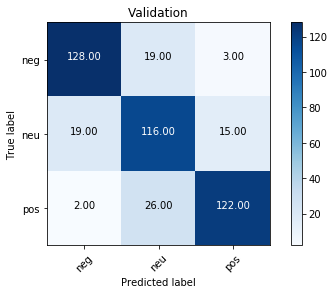

f1 score 0.8133333333333334


In [0]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    :param cm: Confusion matrix
    :param classes: Python list of class names
    :param normalize: Boolean to normalize the matrix
    :param title: Title of the graph
    :param cmap: Colour map
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:.2f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm_test = confusion_matrix(y_true=df_tst["label"], y_pred=pred_labels)
plot_confusion_matrix(cm_test,
                      ['neg', 'neu', 'pos'],
                      normalize=False,
                      title='Validation')
print("f1 score", f1_score(df_tst["label"], pred_labels, average="micro"))

Now we can predict completely made up adhoc examples:

In [0]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]

In [0]:
predictions = getPrediction(pred_sentences)

Voila! We have a sentiment classifier!

In [0]:
predictions[0][2]